# AIS Spoofing Detection for Maritime AIS Data - V3 

In [1]:
# Environment setup and imports
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'  # Fix OpenMP conflict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Visualization
import folium
from folium import plugins
import itertools

print(f"PyTorch version: {torch.__version__}")
print(f"GPU Available: {torch.cuda.is_available()}")
print(f"GPU Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print("All packages loaded successfully")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.9.1+cu126
GPU Available: True
GPU Device: NVIDIA GeForce RTX 4060 Laptop GPU
Numpy version: 1.26.4
Pandas version: 2.3.3
All packages loaded successfully
Using device: cuda


## 1. Data Loading & Preprocessing

Load AIS data from incident slices created in the incident analysis notebook.

In [2]:
# Configuration
data_root = Path("../dataset/piraeus")
output_root = Path("./models")
output_root.mkdir(parents=True, exist_ok=True)

# AIS dataset configuration (from incident_anomaly_labels.ipynb)
cols_primary = ["timestamp", "vessel_id", "lon", "lat", "speed", "course", "heading"]
cols_alias = ["t", "timestamp", "vessel_id", "lon", "lat", "speed", "course", "heading"]

MONTH_ABBR = {
    1: "jan", 2: "feb", 3: "mar", 4: "apr", 5: "may", 6: "jun",
    7: "jul", 8: "aug", 9: "sep", 10: "oct", 11: "nov", 12: "dec"
}

# Years and months to load for comprehensive training
DATA_PERIODS = [
    (2017, [5, 6, 7, 8, 9, 10, 11, 12]),  # May-Dec 2017
    (2018, list(range(1, 13))),            # Full year 2018
    (2019, list(range(1, 13))),            # Full year 2019
]

print("Configuration loaded")
print(f"Data root: {data_root}")
print(f"Loading periods: 2017-2019 (multiple months)")

Configuration loaded
Data root: ..\dataset\piraeus
Loading periods: 2017-2019 (multiple months)


### Spoofing types definitions

In [3]:
# # Spoofing generation utilities
# def generate_off_course_spoofing(df, spoof_ratio=0.15):
#     """Generate off-course deviation spoofing (random bearing shift)."""
#     df_spoofed = df.copy()
#     n_spoof = int(len(df) * spoof_ratio)
#     spoof_indices = np.random.choice(df.index, size=n_spoof, replace=False)
    
#     # Random bearing shift (30-90 degrees)
#     bearing_shift = np.random.uniform(30, 90, size=n_spoof)
#     direction = np.random.choice([-1, 1], size=n_spoof)
#     bearing_shift = bearing_shift * direction
    
#     # Apply shift to coordinates (approximate, in degrees)
#     # 1 degree ≈ 111 km at equator
#     distance_km = np.random.uniform(0.5, 3.0, size=n_spoof)  # 0.5-3 km shift
    
#     df_spoofed.loc[spoof_indices, 'lat'] += (distance_km / 111.0) * np.cos(np.radians(bearing_shift))
#     df_spoofed.loc[spoof_indices, 'lon'] += (distance_km / (111.0 * np.cos(np.radians(df.loc[spoof_indices, 'lat'])))) * np.sin(np.radians(bearing_shift))
    
#     return df_spoofed, spoof_indices


# def generate_track_deviation_spoofing(df, spoof_ratio=0.15):
#     """Generate track deviation spoofing (gradual drift with Gaussian noise)."""
#     df_spoofed = df.copy()
    
#     # Select random vessels for spoofing
#     vessels = df['vessel_id'].unique()
#     n_vessels_spoof = max(1, int(len(vessels) * spoof_ratio))
#     spoof_vessels = np.random.choice(vessels, size=n_vessels_spoof, replace=False)
    
#     spoof_indices = []
    
#     for vessel in spoof_vessels:
#         vessel_mask = df['vessel_id'] == vessel
#         vessel_data = df[vessel_mask].sort_values('timestamp')
        
#         if len(vessel_data) < 10:
#             continue
        
#         # Apply gradual drift to middle portion of trajectory
#         start_idx = len(vessel_data) // 4
#         end_idx = 3 * len(vessel_data) // 4
#         drift_indices = vessel_data.iloc[start_idx:end_idx].index
        
#         # Gaussian noise with increasing magnitude
#         drift_length = len(drift_indices)
#         lat_drift = np.cumsum(np.random.normal(0, 0.0005, drift_length))
#         lon_drift = np.cumsum(np.random.normal(0, 0.0005, drift_length))
        
#         df_spoofed.loc[drift_indices, 'lat'] += lat_drift
#         df_spoofed.loc[drift_indices, 'lon'] += lon_drift
        
#         spoof_indices.extend(drift_indices.tolist())
    
#     return df_spoofed, spoof_indices


# def generate_cpa_violation_spoofing(df, spoof_ratio=0.15):
#     """Generate CPA (Closest Point of Approach) violation spoofing."""
#     df_spoofed = df.copy()
#     n_spoof = int(len(df) * spoof_ratio)
#     spoof_indices = np.random.choice(df.index, size=n_spoof, replace=False)
    
#     # Simulate collision-course trajectories (sudden speed/course changes)
#     df_spoofed.loc[spoof_indices, 'speed'] *= np.random.uniform(1.5, 3.0, size=n_spoof)
    
#     if 'course' in df.columns:
#         # Sudden course change
#         df_spoofed.loc[spoof_indices, 'course'] += np.random.uniform(-45, 45, size=n_spoof)
#         df_spoofed.loc[spoof_indices, 'course'] = df_spoofed.loc[spoof_indices, 'course'] % 360
    
#     return df_spoofed, spoof_indices


# print("Spoofing generation functions defined")
# print("  - Off-course deviation (bearing shift)")
# print("  - Track deviation (gradual drift)")
# print("  - CPA violation (speed/course anomalies)")

In [4]:
# def create_augmented_dataset_v2(df, spoof_ratio=0.3, loiter_ratio=0.05, chunk_size=1_000_000):
#     """
#     Create augmented dataset with genuine, spoofed, and loitering AIS messages.
#     Adds 'is_spoofed' and 'spoof_type' columns for labeling.
    
#     Args:
#         df: Clean AIS DataFrame
#         spoof_ratio: Proportion of data to spoof with standard methods
#         loiter_ratio: Proportion of data to simulate loitering vessels
#         chunk_size: Chunk size for memory-efficient updates
#     Returns:
#         df_augmented: DataFrame with spoofed/loitering points labeled
#     """
#     df_augmented = df.reset_index(drop=True).copy()
#     df_augmented['is_spoofed'] = 0
#     df_augmented['spoof_type'] = 'genuine'

#     # Split spoofing equally among 3 methods
#     ratio_per_method = float(spoof_ratio) / 3.0

#     # Generate spoofed data using existing functions
#     df_off_course, indices_off = generate_off_course_spoofing(df_augmented, ratio_per_method)
#     df_track_dev, indices_track = generate_track_deviation_spoofing(df_augmented, ratio_per_method)
#     df_cpa, indices_cpa = generate_cpa_violation_spoofing(df_augmented, ratio_per_method)

#     # Generate loitering points
#     n_loiter = int(len(df_augmented) * loiter_ratio)
#     loiter_indices = np.random.choice(df_augmented.index, n_loiter, replace=False)
#     jitter = 0.0001  # ~10 meters
#     df_augmented.loc[loiter_indices, 'lat'] += np.random.uniform(-jitter, jitter, size=n_loiter)
#     df_augmented.loc[loiter_indices, 'lon'] += np.random.uniform(-jitter, jitter, size=n_loiter)
#     df_augmented.loc[loiter_indices, 'speed'] = 0.0

#     # --- Memory-efficient label + type updates ---
#     mask = np.zeros(len(df_augmented), dtype=np.uint8)

#     def set_type_and_mask(idxs, typ):
#         if len(idxs) == 0:
#             return
#         num_chunks = max(1, int(np.ceil(len(idxs)/chunk_size)))
#         for chunk in np.array_split(idxs, num_chunks):
#             mask[chunk] = 1
#             df_augmented.loc[chunk, 'spoof_type'] = typ

#     set_type_and_mask(indices_off, 'off_course')
#     set_type_and_mask(indices_track, 'track_deviation')
#     set_type_and_mask(indices_cpa, 'cpa_violation')
#     set_type_and_mask(loiter_indices, 'loitering')

#     df_augmented['is_spoofed'] = mask

#     # Stats
#     total = len(df_augmented)
#     genuine = int((df_augmented['is_spoofed'] == 0).sum())
#     spoofed = total - genuine
#     print("Augmented Dataset Statistics:")
#     print(f"  Total records: {total:,}")
#     print(f"  Genuine: {genuine:,} ({genuine/total*100:.1f}%)")
#     print(f"  Spoofed: {spoofed:,} ({spoofed/total*100:.1f}%)")
#     print(f"  - Off-course: {len(indices_off):,}")
#     print(f"  - Track deviation: {len(indices_track):,}")
#     print(f"  - CPA violation: {len(indices_cpa):,}")
#     print(f"  - Loitering: {len(loiter_indices):,}")

#     return df_augmented

# # Usage
# # np.random.seed(42)
# # ais_augmented = create_augmented_dataset_v2(
# #     ais_clean,
# #     spoof_ratio=0.1,    # 10% spoofed points for traditional types
# #     loiter_ratio=0.05,  # 5% loitering points
# #     chunk_size=1_000_000
# # )

### spoofing type: loitering

In [5]:
# def generate_loitering_segments(
#     df,
#     loiter_length=50,
#     p_loiter=0.05,
#     jitter=0.00005
# ):
#     """
#     Inject single-vessel loitering behavior.

#     Loitering = vessel stays within a tight spatial radius
#     with very low speed for an extended time.
#     """

#     df_aug = df.copy().reset_index(drop=True)

#     df_aug['is_spoofed'] = df_aug.get('is_spoofed', 0)
#     df_aug['spoof_type'] = df_aug.get('spoof_type', 'genuine')

#     for vessel_id, vdf in df_aug.groupby('vessel_id'):
#         if len(vdf) < loiter_length:
#             continue

#         # Randomly decide whether to loiter
#         if np.random.rand() > p_loiter:
#             continue

#         start = np.random.randint(0, len(vdf) - loiter_length)
#         idx = vdf.index[start:start + loiter_length]

#         # Use the vessel's own position as anchor
#         center_lat = df_aug.loc[idx[0], 'lat']
#         center_lon = df_aug.loc[idx[0], 'lon']

#         # Tight spatial jitter
#         df_aug.loc[idx, 'lat'] = center_lat + np.random.uniform(
#             -jitter, jitter, loiter_length
#         )
#         df_aug.loc[idx, 'lon'] = center_lon + np.random.uniform(
#             -jitter, jitter, loiter_length
#         )

#         # Near-zero speed
#         df_aug.loc[idx, 'speed'] = np.random.uniform(0.0, 0.3, loiter_length)

#         df_aug.loc[idx, 'is_spoofed'] = 1
#         df_aug.loc[idx, 'spoof_type'] = 'loitering'

#     return df_aug


Sppofing type: pairwise loitering

In [6]:
# def generate_pairwise_loitering(df, loiter_length=50, jitter=0.00005):
#     """
#     Simulate two vessels loitering together.
    
#     Args:
#         df: AIS dataframe with 'vessel_id', 'lat', 'lon', 'speed', 'timestamp'
#         loiter_length: number of consecutive points to loiter
#         jitter: max deviation around common center

#     Returns:
#         df_aug: dataframe with pairwise loiter points added/modified and labeled
#     """
#     df_aug = df.copy().reset_index(drop=True)
    
#     # Ensure label columns exist
#     df_aug['is_spoofed'] = df_aug.get('is_spoofed', 0)
#     df_aug['spoof_type'] = df_aug.get('spoof_type', 'genuine')
    
#     vessel_ids = df_aug['vessel_id'].unique()
    
#     # Pick two vessels randomly
#     if len(vessel_ids) < 2:
#         return df_aug  # not enough vessels
    
#     v1, v2 = np.random.choice(vessel_ids, 2, replace=False)
    
#     traj1 = df_aug[df_aug['vessel_id'] == v1].sort_values('timestamp')
#     traj2 = df_aug[df_aug['vessel_id'] == v2].sort_values('timestamp')
    
#     # Align trajectories by overlapping indices
#     max_len = min(len(traj1), len(traj2))
#     if max_len < loiter_length:
#         return df_aug  # not enough points
    
#     start_idx = np.random.randint(0, max_len - loiter_length)
#     idx1 = traj1.index[start_idx:start_idx+loiter_length]
#     idx2 = traj2.index[start_idx:start_idx+loiter_length]
    
#     # Common center for loiter
#     center_lat = (df_aug.loc[idx1[0], 'lat'] + df_aug.loc[idx2[0], 'lat']) / 2
#     center_lon = (df_aug.loc[idx1[0], 'lon'] + df_aug.loc[idx2[0], 'lon']) / 2
    
#     # Apply tight jitter around center
#     df_aug.loc[idx1, 'lat'] = center_lat + np.random.uniform(-jitter, jitter, loiter_length)
#     df_aug.loc[idx1, 'lon'] = center_lon + np.random.uniform(-jitter, jitter, loiter_length)
#     df_aug.loc[idx1, 'speed'] = np.random.uniform(0, 0.2, loiter_length)
    
#     df_aug.loc[idx2, 'lat'] = center_lat + np.random.uniform(-jitter, jitter, loiter_length)
#     df_aug.loc[idx2, 'lon'] = center_lon + np.random.uniform(-jitter, jitter, loiter_length)
#     df_aug.loc[idx2, 'speed'] = np.random.uniform(0, 0.2, loiter_length)
    
#     # Label as pairwise loitering
#     df_aug.loc[idx1, 'is_spoofed'] = 1
#     df_aug.loc[idx1, 'spoof_type'] = 'loitering_pair'
#     df_aug.loc[idx2, 'is_spoofed'] = 1
#     df_aug.loc[idx2, 'spoof_type'] = 'loitering_pair'
    
#     return df_aug


### Paths

In [7]:
augmented_path = data_root / "ais_augmented.parquet"
clean_path = data_root / "ais_cleaned.parquet"
loiter_path = data_root / "ais_loiter.parquet"
loiter_pair_path = data_root / "ais_loiter_pair.parquet"

In [8]:
# # Save augmented dataset to parquet
# ais_augmented.to_parquet(augmented_path, index=False)
# print(f"\nAugmented dataset saved to: {augmented_path}")
# print(f"  File size: {augmented_path.stat().st_size / (1024**2):.1f} MB")

# Optional: Load augmented data from parquet on future runs
# ais_augmented = pd.read_parquet(augmented_path)

#### Loading Parquets

In [9]:
# Load previously saved augmented dataset
ais_augmented = pd.read_parquet(augmented_path)
ais_clean = pd.read_parquet(clean_path)

# new_augmented = create_augmented_dataset_v2(
#     ais_clean,
#     spoof_ratio=0.0,    # keep traditional spoofing 0 if you only want loitering
#     loiter_ratio=0.05,  # 5% loitering points
#     chunk_size=1_000_000
# )

# Append new augmented rows
# combined_augmented = pd.concat([existing_augmented, new_augmented], ignore_index=True)

# Save combined dataset
# combined_path = data_root / "ais_augmented_combined.parquet"
# combined_augmented.to_parquet(combined_path, index=False)
# print(f"\nCombined augmented dataset saved to: {combined_path}")
# print(f"  File size: {combined_path.stat().st_size / (1024**2):.1f} MB")


#### Parquet Annalysis

In [10]:
# ais_augmented.describe()

In [11]:
# ais_augmented[ais_augmented['heading'].notnull()]

In [12]:
# ais_clean.describe()

In [13]:
# len(ais_augmented) - len(ais_clean)

In [14]:
# len(ais_augmented)

In [15]:
# len(ais_clean)

In [16]:
# len_clean = len(ais_clean['vessel_id'].unique())
# len_aug = len(ais_augmented['vessel_id'].unique())

# print("Len clean:", len_clean)
# print("Len aug:", len_aug)
# print("Diff:", len_aug - len_clean)
# print("Ratio:", (len_aug - len_clean) / len_clean)
# # print(len_clean, len_aug, len_aug - len_clean)


In [17]:
# # Generate new augmentation (loitering or extra spoof types)
# np.random.seed(42)
# loiter_augmented = generate_loitering_segments(
#     ais_clean,
#     loiter_length=100,
#     p_loiter=0.1
# )

In [18]:
# np.random.seed(42)

# # Generate one pairwise loitering event
# loiter_pair_augmented = generate_pairwise_loitering(
#     ais_clean,
#     loiter_length=100,   # number of points the two vessels loiter together
#     jitter=0.00005       # max deviation from common center
# )


In [19]:
# loiter_pair_augmented.to_parquet(loiter_pair_path, index = False)
# loiter_augmented.to_parquet(loiter_path, index = False)
# load saved parquet
# loiter_augmented = pd.read_parquet(loiter_path)
# loiter_pair_augmented = pd.read_parquet(loiter_pair_path)

## 3. Feature Engineering & Sequence Creation

Extract features (lat, lon, SOG, COG) and create temporal sequences for Bi-LSTM input.

In [20]:
# ais_featured.describe()

## Extract Features

In [21]:
# Feature extraction (Algorithm 1: Feature Extraction step)
def extract_features(df):
    """Extract relevant features for Bi-LSTM model."""
    df = df.copy()
    
    # Core features from paper
    features = ['lat', 'lon', 'speed']
    
    if 'course' in df.columns:
        features.append('course')
    
    # Temporal features
    df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
    df['day_of_week'] = pd.to_datetime(df['timestamp']).dt.dayofweek
    features.extend(['hour', 'day_of_week'])
    
    # Velocity components (if course available)
    if 'course' in df.columns:
        df['velocity_x'] = df['speed'] * np.cos(np.radians(df['course']))
        df['velocity_y'] = df['speed'] * np.sin(np.radians(df['course']))
        features.extend(['velocity_x', 'velocity_y'])
    
    # Calculate inter-point distances (movement magnitude)
    df = df.sort_values(['vessel_id', 'timestamp'])
    df['lat_diff'] = df.groupby('vessel_id')['lat'].diff()
    df['lon_diff'] = df.groupby('vessel_id')['lon'].diff()
    df['distance'] = np.sqrt(df['lat_diff']**2 + df['lon_diff']**2)
    features.append('distance')
    
    # Fill NaN values from diff operations
    df[features] = df[features].fillna(method='bfill').fillna(method='ffill').fillna(0)
    
    print(f"Feature Extraction Complete:")
    print(f"  Features: {features}")
    print(f"  Feature matrix shape: {df[features].shape}")
    
    return df, features

# Extract features
ais_featured, feature_cols = extract_features(ais_augmented)

# Display sample
print(f"\nSample Features:")
print(ais_featured[feature_cols + ['is_spoofed']].head(10))

Feature Extraction Complete:
  Features: ['lat', 'lon', 'speed', 'course', 'hour', 'day_of_week', 'velocity_x', 'velocity_y', 'distance']
  Feature matrix shape: (37807152, 9)

Sample Features:
         lat        lon  speed      course  hour  day_of_week  velocity_x  \
0  37.921783  23.641014    7.9   75.900002    10            6    1.924559   
1  37.922092  23.642525    8.1   74.400002    10            6    2.178251   
2  37.922375  23.643847    7.9   75.900002    10            6    1.924559   
3  37.928677  23.657753    7.1  350.799988    11            6    7.008667   
4  37.929634  23.657440    7.7  338.200012    11            6    7.149342   
5  37.932297  23.654945    7.9  308.600006    11            6    4.928648   
6  37.932781  23.653702    7.2  282.000000    11            6    1.496963   
7  37.932716  23.652637    5.6  258.000000    11            6   -1.164307   
8  37.932480  23.651138    4.2  266.700012    11            6   -0.241768   
9  37.932426  23.650337    4.7  262.

## normalize Features

In [22]:
# Feature normalization (Algorithm 1: Feature Scaling)
def normalize_features(df, feature_cols, fit_scaler=True, scaler=None):
    """Normalize features using StandardScaler."""
    if fit_scaler:
        scaler = StandardScaler()
        df[feature_cols] = scaler.fit_transform(df[feature_cols])
        print(f"Features normalized (fitted new scaler)")
    else:
        df[feature_cols] = scaler.transform(df[feature_cols])
        print(f"Features normalized (using existing scaler)")
    
    return df, scaler

# Normalize features
ais_normalized, feature_scaler = normalize_features(
    ais_featured, 
    feature_cols, 
    fit_scaler=True
)

print(f"\nNormalized Feature Statistics:")
print(ais_normalized[feature_cols].describe())

Features normalized (fitted new scaler)

Normalized Feature Statistics:
                lat           lon         speed        course          hour  \
count  3.780715e+07  3.780715e+07  3.780715e+07  3.780715e+07  3.780715e+07   
mean   2.346945e-14  7.521373e-15  2.136716e-15 -2.242647e-15  5.370311e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.343588e+01 -1.292370e+01 -4.413980e-01 -1.515801e+00 -1.715029e+00   
25%   -8.922559e-02 -6.597932e-01 -4.413980e-01 -9.557656e-01 -7.960809e-01   
50%    2.368593e-01  3.563888e-02 -4.413980e-01  7.374504e-02 -3.029044e-02   
75%    5.292614e-01  6.852966e-01 -1.642169e-01  8.820629e-01  8.886581e-01   
max    4.430866e+00  6.754714e+00  4.297860e+01  1.630084e+00  1.807607e+00   

        day_of_week    velocity_x    velocity_y      distance  
count  3.780715e+07  3.780715e+07  3.780715e+07  3.780715e+07  
mean   8.655480e-17  2.497574e-17  1.368795e-17 -3.944187e-16  
std    1.000000e+00  1.0

## Create Sequences

In [23]:
# Create sequences for LSTM (temporal windows) with vessel/sequence subsampling only
def create_sequences(df, feature_cols, sequence_length=128, stride=32, *,
                     max_vessels=None, sequence_sample_frac=None, random_state=42):
    """
    Memory-efficient creation of temporal sequences for LSTM input.
    - Keeps full trajectories per selected vessel (no row-level sampling).
    - Preallocates with a tight upper bound; auto-grows if ever exceeded.
    """
    rng = np.random.default_rng(random_state)
    df_use = df

    # Optional vessel cap
    vessel_ids = df_use['vessel_id'].drop_duplicates().to_numpy()
    if max_vessels is not None and len(vessel_ids) > max_vessels:
        keep_ids = rng.choice(vessel_ids, size=max_vessels, replace=False)
        df_use = df_use[df_use['vessel_id'].isin(keep_ids)]

    # Exact upper bound on sequences
    def vessel_seq_cap(n_rows):
        if n_rows < sequence_length:
            return 0
        return 1 + max(0, n_rows - sequence_length) // stride

    n_features = len(feature_cols)
    max_sequences = int(sum(vessel_seq_cap(len(v)) for _, v in df_use.groupby('vessel_id')))
    max_sequences = max(1, max_sequences)

    X_array = np.empty((max_sequences, sequence_length, n_features), dtype=np.float32)
    y_array = np.empty((max_sequences,), dtype=np.uint8)
    seq_idx = 0

    # Helper to grow if the bound was underestimated (should be rare)
    def ensure_capacity(idx):
        nonlocal X_array, y_array
        if idx < len(X_array):
            return
        new_size = int(len(X_array) * 1.5) + 1
        X_grow = np.empty((new_size, sequence_length, n_features), dtype=np.float32)
        y_grow = np.empty((new_size,), dtype=np.uint8)
        X_grow[:len(X_array)] = X_array
        y_grow[:len(y_array)] = y_array
        X_array, y_array = X_grow, y_grow

    for _, vessel_data in df_use.groupby('vessel_id'):
        vessel_data = vessel_data.sort_values('timestamp')
        features = vessel_data[feature_cols].values
        labels = vessel_data['is_spoofed'].values
        if len(features) < sequence_length:
            continue

        for i in range(0, len(features) - sequence_length + 1, stride):
            ensure_capacity(seq_idx)
            seq_features = features[i:i+sequence_length]
            seq_label = labels[i:i+sequence_length]
            # Label as spoofed only if MAJORITY (>50%) of points are spoofed
            is_spoofed = int(seq_label.sum() > (sequence_length // 2))
            X_array[seq_idx] = seq_features
            y_array[seq_idx] = is_spoofed
            seq_idx += 1

    # Trim
    X_array = X_array[:seq_idx]
    y_array = y_array[:seq_idx]

    # Optional sequence-level subsampling
    if sequence_sample_frac is not None and 0 < sequence_sample_frac < 1.0 and len(X_array) > 0:
        n_keep = max(1, int(len(X_array) * sequence_sample_frac))
        idx = rng.choice(len(X_array), size=n_keep, replace=False)
        X_array = X_array[idx]
        y_array = y_array[idx]

    print("Sequence Creation:")
    print(f"  Sequence length: {sequence_length} timesteps")
    print(f"  Stride: {stride}")
    print(f"  Vessels used: {df_use['vessel_id'].nunique():,}")
    print(f"  Total sequences: {len(X_array):,}")
    print(f"  Genuine sequences: {(y_array == 0).sum():,} ({(y_array == 0).sum()/len(y_array)*100:.1f}%)")
    print(f"  Spoofed sequences: {(y_array == 1).sum():,} ({(y_array == 1).sum()/len(y_array)*100:.1f}%)")
    print(f"  Shape: X={X_array.shape}, y={y_array.shape}")

    return X_array, y_array

# Create sequences
SEQUENCE_LENGTH = 128
STRIDE = 32

# Use vessel cap and sequence-level subsample to manage memory (adjust as needed)
X_sequences, y_labels = create_sequences(
    ais_normalized,
    feature_cols,
    sequence_length=SEQUENCE_LENGTH,
    stride=STRIDE,
    max_vessels=2000,           # keep full trajectories for a subset of vessels
    sequence_sample_frac=0.2,   # keep 20% of sequences after creation
    random_state=42
 )

Sequence Creation:
  Sequence length: 128 timesteps
  Stride: 32
  Vessels used: 2,000
  Total sequences: 91,728
  Genuine sequences: 90,982 (99.2%)
  Spoofed sequences: 746 (0.8%)
  Shape: X=(91728, 128, 9), y=(91728,)


#### Vessel aware split

In [24]:
# # Train/test split (Algorithm 1: train_test_split)
# # Split by vessel to avoid leakage
# def vessel_aware_split(X, y, df, test_size=0.2, val_size=0.1):
#     """
#     Split data by vessel to prevent data leakage.
#     """
#     # Get unique vessels
#     vessels = df['vessel_id'].unique()
#     n_vessels = len(vessels)
    
#     # Shuffle vessels
#     np.random.shuffle(vessels)
    
#     # Calculate split indices
#     test_idx = int(n_vessels * (1 - test_size))
#     val_idx = int(test_idx * (1 - val_size))
    
#     train_vessels = vessels[:val_idx]
#     val_vessels = vessels[val_idx:test_idx]
#     test_vessels = vessels[test_idx:]
    
#     # Create vessel-to-sequences mapping
#     vessel_to_seq = {}
#     for idx, (vessel_id, _) in enumerate(df.groupby('vessel_id')):
#         vessel_to_seq[vessel_id] = []
    
#     # Map sequences to vessels (approximate based on order)
#     # This is simplified; in production, track vessel_id through sequence creation
#     sequences_per_vessel = len(X) // n_vessels
    
#     train_mask = []
#     val_mask = []
#     test_mask = []
    
#     for i in range(len(X)):
#         # Simple assignment (can be improved with proper tracking)
#         vessel_idx = min(i // max(1, sequences_per_vessel), n_vessels - 1)
#         vessel = vessels[vessel_idx]
        
#         if vessel in train_vessels:
#             train_mask.append(i)
#         elif vessel in val_vessels:
#             val_mask.append(i)
#         else:
#             test_mask.append(i)
    
#     X_train = X[train_mask]
#     y_train = y[train_mask]
#     X_val = X[val_mask]
#     y_val = y[val_mask]
#     X_test = X[test_mask]
#     y_test = y[test_mask]
    
#     print(f"Data Split (vessel-aware):")
#     print(f"   Train: {len(X_train):,} sequences ({len(X_train)/len(X)*100:.1f}%)")
#     print(f"   Val:   {len(X_val):,} sequences ({len(X_val)/len(X)*100:.1f}%)")
#     print(f"   Test:  {len(X_test):,} sequences ({len(X_test)/len(X)*100:.1f}%)")
#     print(f"\n   Train - Genuine: {(y_train==0).sum()}, Spoofed: {(y_train==1).sum()}")
#     print(f"   Val   - Genuine: {(y_val==0).sum()}, Spoofed: {(y_val==1).sum()}")
#     print(f"   Test  - Genuine: {(y_test==0).sum()}, Spoofed: {(y_test==1).sum()}")
    
#     return X_train, X_val, X_test, y_train, y_val, y_test

# X_train, X_val, X_test, y_train, y_val, y_test = vessel_aware_split(
#     X_sequences, y_labels, ais_clean, test_size=0.2, val_size=0.1
# )
# # # Alternative: Simple random split (faster, but may have leakage)
# # X_train, X_test, y_train, y_test = train_test_split(
# #     X_sequences, y_labels, test_size=0.2, random_state=42, stratify=y_labels
# # )

# # X_train, X_val, y_train, y_val = train_test_split(
# #     X_train, y_train, test_size=0.125, random_state=42, stratify=y_train  # 0.125 * 0.8 = 0.1 of total
# # )

# print(f"Data Split (random stratified):")
# print(f"  Train: {len(X_train):,} sequences")
# print(f"  Val:   {len(X_val):,} sequences")
# print(f"  Test:  {len(X_test):,} sequences")
# print(f"\n  Train - Genuine: {(y_train==0).sum()}, Spoofed: {(y_train==1).sum()}")
# print(f"  Val   - Genuine: {(y_val==0).sum()}, Spoofed: {(y_val==1).sum()}")
# print(f"  Test  - Genuine: {(y_test==0).sum()}, Spoofed: {(y_test==1).sum()}")

#### Split info X_Train...

In [25]:
X_train = np.load(output_root / "X_train.npy")
y_train = np.load(output_root / "y_train.npy")
X_val = np.load(output_root / "X_val.npy")
y_val = np.load(output_root / "y_val.npy")
X_test = np.load(output_root / "X_test.npy")
y_test = np.load(output_root / "y_test.npy")


In [26]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((64925, 128, 9), (64925,), (7225, 128, 9), (7225,), (19578, 128, 9), (19578,))

In [27]:
pd.DataFrame(next(iter(X_train))).describe()

,0,1,2,3,4,5,6,7,8
count,128.000000,128.000000,128.000000,128.000000,1.280000e+02,128.000000,128.000000,128.000000,128.000000
mean,0.587324,-0.299207,-0.371760,0.382042,-3.029043e-02,1.036356,0.019586,-0.067148,-0.047399
std,0.045261,0.056468,0.053643,1.110155,2.430953e-08,0.000001,0.067045,0.075039,0.714092
min,0.565966,-0.571059,-0.426810,-1.515801,-3.029044e-02,1.036356,-0.097404,-0.402060,-0.252259
25%,0.577156,-0.305724,-0.412221,-1.258013,-3.029044e-02,1.036356,-0.024177,-0.080445,-0.252259
50%,0.580625,-0.300116,-0.397633,0.656171,-3.029044e-02,1.036356,0.013090,-0.045999,-0.252259
75%,0.581520,-0.298854,-0.344872,1.131331,-3.029044e-02,1.036356,0.048936,-0.021309,-0.248956
max,0.904248,0.069287,-0.148634,1.622981,-3.029044e-02,1.036356,0.314927,0.128675,3.130754


In [28]:
pd.DataFrame(next(iter(X_val))).describe()

,0,1,2,3,4,5,6,7,8
count,128.000000,128.000000,128.000000,128.000000,128.000000,1.280000e+02,128.000000,128.000000,128.000000
mean,-4.430433,-2.934015,-0.057427,0.111781,-0.641726,1.240721e-02,0.281269,0.122194,0.000937
std,0.338113,0.163245,0.482858,1.013595,0.137924,1.308975e-08,0.540830,0.426659,0.779541
min,-4.660569,-3.346496,-0.441398,-1.348894,-0.949239,1.240721e-02,-0.688762,-0.858537,-0.252259
25%,-4.660569,-3.041264,-0.441398,-1.288817,-0.642923,1.240721e-02,-0.017055,-0.021625,-0.252259
50%,-4.659562,-3.041264,-0.441398,0.871577,-0.642923,1.240721e-02,-0.017055,-0.021625,-0.207307
75%,-4.116469,-2.779851,0.521442,0.871577,-0.489765,1.240721e-02,0.981584,0.514605,-0.141755
max,-3.704695,-2.505339,2.096745,1.353072,-0.489765,1.240721e-02,2.333107,2.248121,4.789611


In [29]:
pd.DataFrame(next(iter(X_test))).describe()

,0,1,2,3,4,5,6,7,8
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,0.877806,-1.452802,0.152651,0.054946,-0.446689,1.036356,-0.054234,0.150664,0.061324
std,0.075474,0.251205,0.590473,0.946681,0.125942,0.000001,0.380277,1.177840,0.867531
min,0.769741,-1.743770,-0.441398,-1.446766,-0.642923,1.036356,-1.054469,-4.416827,-0.251929
25%,0.810277,-1.711529,-0.441398,-0.681486,-0.489765,1.036356,-0.175802,-0.021625,-0.250095
50%,0.889812,-1.494473,0.375557,-0.402070,-0.489765,1.036356,-0.017055,-0.021625,-0.182987
75%,0.921705,-1.181719,0.539049,1.032646,-0.336607,1.036356,-0.010991,1.146545,-0.059678
max,1.248797,-0.562492,2.604131,1.492889,-0.183449,1.036356,0.843676,4.604335,4.948783


In [30]:
pd.DataFrame(y_train).describe()

,0
count,64925.000000
mean,0.008163
std,0.089982
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [31]:
pd.DataFrame(y_val).describe()

,0
count,7225.000000
mean,0.010519
std,0.102029
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [32]:
pd.DataFrame(y_test).describe()

,0
count,19578.000000
mean,0.007151
std,0.084262
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [33]:
len(X_train), len(X_val), len(X_test), len(y_train), len(y_val), len(y_test), len(X_train) + len(X_val) + len(X_test), len(y_train) + len(y_val) + len(y_test)

(64925, 7225, 19578, 64925, 7225, 19578, 91728, 91728)

## Loading

In [34]:

BATCH_SIZE = 30  

# Calculate class weights to handle imbalance
# This addresses the 99.9% precision / 1.63% recall problem
n_genuine = (y_train == 0).sum()
n_spoofed = (y_train == 1).sum()
total_samples = len(y_train)

# Weight inversely proportional to class frequency
weight_genuine = total_samples / (2.0 * n_genuine)
weight_spoofed = total_samples / (2.0 * n_spoofed)

print(f"Class Distribution in Training Set:")
print(f"  Genuine: {n_genuine:,} ({n_genuine/total_samples*100:.2f}%)")
print(f"  Spoofed: {n_spoofed:,} ({n_spoofed/total_samples*100:.2f}%)")
print(f"\nClass Weights (V2 Improvement):")
print(f"  Genuine weight: {weight_genuine:.4f}")
print(f"  Spoofed weight: {weight_spoofed:.4f}")

# Create data loaders
train_dataset = TensorDataset(
    torch.from_numpy(X_train).float(),
    # torch.from_numpy(y_train).float().reshape(-1, 1)
)
val_dataset = TensorDataset(
    torch.from_numpy(X_val).float(),
    # torch.from_numpy(y_val).float().reshape(-1, 1)
)

test_dataset = TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(y_test).float().reshape(-1, 1)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Class Distribution in Training Set:
  Genuine: 64,395 (99.18%)
  Spoofed: 530 (0.82%)

Class Weights (V2 Improvement):
  Genuine weight: 0.5041
  Spoofed weight: 61.2500


In [35]:
torch.from_numpy(y_train)

tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)

In [36]:
for batch in train_loader:
    print(type(batch))
    print(batch)
    break
# for x, y in train_loader:
for x in train_loader:
    # print(len(x))
    [x] = x
    print("x shape:", x.shape)
    # print("y shape:", y.shape)
    print("x dtype:", x.dtype)
    break


<class 'list'>
[tensor([[[ 6.6131e-01, -1.2995e+00, -4.4140e-01,  ..., -1.7055e-02,
          -2.1625e-02, -2.4929e-01],
         [ 6.6131e-01, -1.2995e+00, -4.2681e-01,  ..., -2.2250e-02,
          -1.7295e-04, -2.5226e-01],
         [ 6.6131e-01, -1.2995e+00, -4.4140e-01,  ..., -1.7055e-02,
          -2.1625e-02, -2.5226e-01],
         ...,
         [ 6.6131e-01, -1.2991e+00, -4.2681e-01,  ..., -2.1085e-02,
           2.8903e-04, -2.5226e-01],
         [ 6.6131e-01, -1.2995e+00, -4.2681e-01,  ..., -2.4230e-02,
          -1.2654e-03, -2.4929e-01],
         [ 6.6131e-01, -1.2995e+00, -4.1222e-01,  ..., -3.1404e-02,
           1.9094e-02, -2.5226e-01]],

        [[-1.0635e-01,  1.5862e+00, -4.4140e-01,  ..., -1.7055e-02,
          -2.1625e-02, -2.5094e-01],
         [-1.0635e-01,  1.5863e+00, -4.4140e-01,  ..., -1.7055e-02,
          -2.1625e-02, -2.5127e-01],
         [-1.0635e-01,  1.5861e+00, -4.4140e-01,  ..., -1.7055e-02,
          -2.1625e-02, -2.5061e-01],
         ...,
         

### Darts Time series 

In [37]:
# from darts import TimeSeries
# import numpy as np

# def sequences_to_timeseries(X):
#     """
#     X: (num_sequences, window_size, num_features)
#     returns list of TimeSeries objects (one per sequence)
#     """
#     series_list = []
#     for seq in X:
#         ts = TimeSeries.from_values(seq)  # shape: (window_size, num_features)
#         series_list.append(ts)
#     return series_list

# train_series = sequences_to_timeseries(X_train)
# val_series   = sequences_to_timeseries(X_val)
# test_series  = sequences_to_timeseries(X_test)

# print(f"Data Split (random stratified):")
# print(f"  Train: {len(train_series):,} sequences")
# print(f"  Val:   {len(val_series):,} sequences")
# print(f"  Test:  {len(test_series):,} sequences")
# print(f"\n  Train - Genuine: {(y_train==0).sum()}, Spoofed: {(y_train==1).sum()}")
# print(f"  Val   - Genuine: {(y_val==0).sum()}, Spoofed: {(y_val==1).sum()}")
# print(f"  Test  - Genuine: {(y_test==0).sum()}, Spoofed: {(y_test==1).sum()}")

In [38]:
# def labels_to_timeseries(y, window_size):
#     """
#     y: (num_sequences,) binary labels
#     returns: List[TimeSeries] with shape (window_size, 1)
#     """
#     labels_ts = []
#     for label in y:
#         arr = np.full((window_size, 1), label, dtype=np.int8)
#         ts = TimeSeries.from_values(arr)
#         labels_ts.append(ts)
#     return labels_ts

In [39]:
# window_size = X_test.shape[1]

# test_labels = labels_to_timeseries(y_test, window_size)
# val_labels  = labels_to_timeseries(y_val, window_size)


In [40]:
# def has_anomalies(labels):
#     return any(ts.values().max() == 1 for ts in labels)

# print("Test anomalies:", has_anomalies(test_labels))
# print("Val anomalies :", has_anomalies(val_labels))

# Training

In [41]:
import torch
from torch import nn
import torch.nn.functional as F

def hierarchical_contrastive_loss(z1, z2, alpha=0.5, temporal_unit=0):
    loss = torch.tensor(0., device=z1.device)
    d = 0
    while z1.size(1) > 1:
        if alpha != 0:
            loss += alpha * instance_contrastive_loss(z1, z2)
        if d >= temporal_unit:
            if 1 - alpha != 0:
                loss += (1 - alpha) * temporal_contrastive_loss(z1, z2)
        d += 1
        z1 = F.max_pool1d(z1.transpose(1, 2), kernel_size=2).transpose(1, 2)
        z2 = F.max_pool1d(z2.transpose(1, 2), kernel_size=2).transpose(1, 2)
    if z1.size(1) == 1:
        if alpha != 0:
            loss += alpha * instance_contrastive_loss(z1, z2)
        d += 1
    return loss / d

def instance_contrastive_loss(z1, z2):
    B, T = z1.size(0), z1.size(1)
    if B == 1:
        return z1.new_tensor(0.)
    z = torch.cat([z1, z2], dim=0)  # 2B x T x C
    z = z.transpose(0, 1)  # T x 2B x C
    sim = torch.matmul(z, z.transpose(1, 2))  # T x 2B x 2B
    logits = torch.tril(sim, diagonal=-1)[:, :, :-1]    # T x 2B x (2B-1)
    logits += torch.triu(sim, diagonal=1)[:, :, 1:]
    logits = -F.log_softmax(logits, dim=-1)
    
    i = torch.arange(B, device=z1.device)
    loss = (logits[:, i, B + i - 1].mean() + logits[:, B + i, i].mean()) / 2
    return loss

def temporal_contrastive_loss(z1, z2):
    B, T = z1.size(0), z1.size(1)
    if T == 1:
        return z1.new_tensor(0.)
    z = torch.cat([z1, z2], dim=1)  # B x 2T x C
    sim = torch.matmul(z, z.transpose(1, 2))  # B x 2T x 2T
    logits = torch.tril(sim, diagonal=-1)[:, :, :-1]    # B x 2T x (2T-1)
    logits += torch.triu(sim, diagonal=1)[:, :, 1:]
    logits = -F.log_softmax(logits, dim=-1)
    
    t = torch.arange(T, device=z1.device)
    loss = (logits[:, t, T + t - 1].mean() + logits[:, T + t, t].mean()) / 2
    return loss

In [42]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np

class SamePadConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, groups=1):
        super().__init__()
        self.receptive_field = (kernel_size - 1) * dilation + 1
        padding = self.receptive_field // 2
        self.conv = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            padding=padding,
            dilation=dilation,
            groups=groups
        )
        self.remove = 1 if self.receptive_field % 2 == 0 else 0
        
    def forward(self, x):
        out = self.conv(x)
        if self.remove > 0:
            out = out[:, :, : -self.remove]
        return out
    
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, final=False):
        super().__init__()
        self.conv1 = SamePadConv(in_channels, out_channels, kernel_size, dilation=dilation)
        self.conv2 = SamePadConv(out_channels, out_channels, kernel_size, dilation=dilation)
        self.projector = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels or final else None
    
    def forward(self, x):
        residual = x if self.projector is None else self.projector(x)
        x = F.gelu(x)
        x = self.conv1(x)
        x = F.gelu(x)
        x = self.conv2(x)
        return x + residual

class DilatedConvEncoder(nn.Module):
    def __init__(self, in_channels, channels, kernel_size):
        super().__init__()
        self.net = nn.Sequential(*[
            ConvBlock(
                channels[i-1] if i > 0 else in_channels,
                channels[i],
                kernel_size=kernel_size,
                dilation=2**i,
                final=(i == len(channels)-1)
            )
            for i in range(len(channels))
        ])
        
    def forward(self, x):
        return self.net(x)

In [43]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np

def generate_continuous_mask(B, T, n=5, l=0.1):
    res = torch.full((B, T), True, dtype=torch.bool)
    if isinstance(n, float):
        n = int(n * T)
    n = max(min(n, T // 2), 1)
    
    if isinstance(l, float):
        l = int(l * T)
    l = max(l, 1)
    
    for i in range(B):
        for _ in range(n):
            t = np.random.randint(T-l+1)
            res[i, t:t+l] = False
    return res

def generate_binomial_mask(B, T, p=0.5):
    return torch.from_numpy(np.random.binomial(1, p, size=(B, T))).to(torch.bool)

class TSEncoder(nn.Module):
    def __init__(self, input_dims, output_dims, hidden_dims=64, depth=10, mask_mode='binomial'):
        super().__init__()
        self.input_dims = input_dims
        self.output_dims = output_dims
        self.hidden_dims = hidden_dims
        self.mask_mode = mask_mode
        self.input_fc = nn.Linear(input_dims, hidden_dims)
        self.feature_extractor = DilatedConvEncoder(
            hidden_dims,
            [hidden_dims] * depth + [output_dims],
            kernel_size=3
        )
        self.repr_dropout = nn.Dropout(p=0.1)
        
    def forward(self, x, mask=None):  # x: B x T x input_dims
        nan_mask = ~x.isnan().any(axis=-1)
        x[~nan_mask] = 0
        x = self.input_fc(x)  # B x T x Ch
        
        # generate & apply mask
        if mask is None:
            if self.training:
                mask = self.mask_mode
            else:
                mask = 'all_true'
        
        if mask == 'binomial':
            mask = generate_binomial_mask(x.size(0), x.size(1)).to(x.device)
        elif mask == 'continuous':
            mask = generate_continuous_mask(x.size(0), x.size(1)).to(x.device)
        elif mask == 'all_true':
            mask = x.new_full((x.size(0), x.size(1)), True, dtype=torch.bool)
        elif mask == 'all_false':
            mask = x.new_full((x.size(0), x.size(1)), False, dtype=torch.bool)
        elif mask == 'mask_last':
            mask = x.new_full((x.size(0), x.size(1)), True, dtype=torch.bool)
            mask[:, -1] = False
        
        mask &= nan_mask
        x[~mask] = 0
        
        # conv encoder
        x = x.transpose(1, 2)  # B x Ch x T
        x = self.repr_dropout(self.feature_extractor(x))  # B x Co x T
        x = x.transpose(1, 2)  # B x T x Co
        
        return x
        

In [44]:
import os
import numpy as np
import pickle
import torch
import random
from datetime import datetime

def pkl_save(name, var):
    with open(name, 'wb') as f:
        pickle.dump(var, f)

def pkl_load(name):
    with open(name, 'rb') as f:
        return pickle.load(f)
    
def torch_pad_nan(arr, left=0, right=0, dim=0):
    if left > 0:
        padshape = list(arr.shape)
        padshape[dim] = left
        arr = torch.cat((torch.full(padshape, np.nan), arr), dim=dim)
    if right > 0:
        padshape = list(arr.shape)
        padshape[dim] = right
        arr = torch.cat((arr, torch.full(padshape, np.nan)), dim=dim)
    return arr
    
def pad_nan_to_target(array, target_length, axis=0, both_side=False):
    assert array.dtype in [np.float16, np.float32, np.float64]
    pad_size = target_length - array.shape[axis]
    if pad_size <= 0:
        return array
    npad = [(0, 0)] * array.ndim
    if both_side:
        npad[axis] = (pad_size // 2, pad_size - pad_size//2)
    else:
        npad[axis] = (0, pad_size)
    return np.pad(array, pad_width=npad, mode='constant', constant_values=np.nan)

def split_with_nan(x, sections, axis=0):
    assert x.dtype in [np.float16, np.float32, np.float64]
    arrs = np.array_split(x, sections, axis=axis)
    target_length = arrs[0].shape[axis]
    for i in range(len(arrs)):
        arrs[i] = pad_nan_to_target(arrs[i], target_length, axis=axis)
    return arrs

def take_per_row(A, indx, num_elem):
    all_indx = indx[:,None] + np.arange(num_elem)
    return A[torch.arange(all_indx.shape[0])[:,None], all_indx]

def centerize_vary_length_series(x):
    prefix_zeros = np.argmax(~np.isnan(x).all(axis=-1), axis=1)
    suffix_zeros = np.argmax(~np.isnan(x[:, ::-1]).all(axis=-1), axis=1)
    offset = (prefix_zeros + suffix_zeros) // 2 - prefix_zeros
    rows, column_indices = np.ogrid[:x.shape[0], :x.shape[1]]
    offset[offset < 0] += x.shape[1]
    column_indices = column_indices - offset[:, np.newaxis]
    return x[rows, column_indices]

def data_dropout(arr, p):
    B, T = arr.shape[0], arr.shape[1]
    mask = np.full(B*T, False, dtype=np.bool)
    ele_sel = np.random.choice(
        B*T,
        size=int(B*T*p),
        replace=False
    )
    mask[ele_sel] = True
    res = arr.copy()
    res[mask.reshape(B, T)] = np.nan
    return res

def name_with_datetime(prefix='default'):
    now = datetime.now()
    return prefix + '_' + now.strftime("%Y%m%d_%H%M%S")

def init_dl_program(
    device_name,
    seed=None,
    use_cudnn=True,
    deterministic=False,
    benchmark=False,
    use_tf32=False,
    max_threads=None
):
    import torch
    if max_threads is not None:
        torch.set_num_threads(max_threads)  # intraop
        if torch.get_num_interop_threads() != max_threads:
            torch.set_num_interop_threads(max_threads)  # interop
        try:
            import mkl
        except:
            pass
        else:
            mkl.set_num_threads(max_threads)
        
    if seed is not None:
        random.seed(seed)
        seed += 1
        np.random.seed(seed)
        seed += 1
        torch.manual_seed(seed)
        
    if isinstance(device_name, (str, int)):
        device_name = [device_name]
    
    devices = []
    for t in reversed(device_name):
        t_device = torch.device(t)
        devices.append(t_device)
        if t_device.type == 'cuda':
            assert torch.cuda.is_available()
            torch.cuda.set_device(t_device)
            if seed is not None:
                seed += 1
                torch.cuda.manual_seed(seed)
    devices.reverse()
    torch.backends.cudnn.enabled = use_cudnn
    torch.backends.cudnn.deterministic = deterministic
    torch.backends.cudnn.benchmark = benchmark
    
    if hasattr(torch.backends.cudnn, 'allow_tf32'):
        torch.backends.cudnn.allow_tf32 = use_tf32
        torch.backends.cuda.matmul.allow_tf32 = use_tf32
        
    return devices if len(devices) > 1 else devices[0]


#### TS2Vec

In [45]:
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import math

class TS2Vec:
    '''The TS2Vec model'''
    
    def __init__(
        self,
        input_dims,
        output_dims=320,
        hidden_dims=64,
        depth=10,
        device='cuda',
        lr=0.001,
        batch_size=16,
        max_train_length=None,
        temporal_unit=0,
        after_iter_callback=None,
        after_epoch_callback=None
    ):
        ''' Initialize a TS2Vec model.
        
        Args:
            input_dims (int): The input dimension. For a univariate time series, this should be set to 1.
            output_dims (int): The representation dimension.
            hidden_dims (int): The hidden dimension of the encoder.
            depth (int): The number of hidden residual blocks in the encoder.
            device (int): The gpu used for training and inference.
            lr (int): The learning rate.
            batch_size (int): The batch size.
            max_train_length (Union[int, NoneType]): The maximum allowed sequence length for training. For sequence with a length greater than <max_train_length>, it would be cropped into some sequences, each of which has a length less than <max_train_length>.
            temporal_unit (int): The minimum unit to perform temporal contrast. When training on a very long sequence, this param helps to reduce the cost of time and memory.
            after_iter_callback (Union[Callable, NoneType]): A callback function that would be called after each iteration.
            after_epoch_callback (Union[Callable, NoneType]): A callback function that would be called after each epoch.
        '''
        
        super().__init__()
        self.device = device
        self.lr = lr
        self.batch_size = batch_size
        self.max_train_length = max_train_length
        self.temporal_unit = temporal_unit
        
        self._net = TSEncoder(input_dims=input_dims, output_dims=output_dims, hidden_dims=hidden_dims, depth=depth).to(self.device)
        self.net = torch.optim.swa_utils.AveragedModel(self._net)
        self.net.update_parameters(self._net)
        
        self.after_iter_callback = after_iter_callback
        self.after_epoch_callback = after_epoch_callback
        
        self.n_epochs = 0
        self.n_iters = 0
    
    def fit(self, train_data, n_epochs=None, n_iters=None, verbose=False):
        ''' Training the TS2Vec model.
        
        Args:
            train_data (numpy.ndarray): The training data. It should have a shape of (n_instance, n_timestamps, n_features). All missing data should be set to NaN.
            n_epochs (Union[int, NoneType]): The number of epochs. When this reaches, the training stops.
            n_iters (Union[int, NoneType]): The number of iterations. When this reaches, the training stops. If both n_epochs and n_iters are not specified, a default setting would be used that sets n_iters to 200 for a dataset with size <= 100000, 600 otherwise.
            verbose (bool): Whether to print the training loss after each epoch.
            
        Returns:
            loss_log: a list containing the training losses on each epoch.
        '''
        assert train_data.ndim == 3
        
        if n_iters is None and n_epochs is None:
            n_iters = 200 if train_data.size <= 100000 else 600  # default param for n_iters
        
        if self.max_train_length is not None:
            sections = train_data.shape[1] // self.max_train_length
            if sections >= 2:
                train_data = np.concatenate(split_with_nan(train_data, sections, axis=1), axis=0)

        temporal_missing = np.isnan(train_data).all(axis=-1).any(axis=0)
        if temporal_missing[0] or temporal_missing[-1]:
            train_data = centerize_vary_length_series(train_data)
                
        train_data = train_data[~np.isnan(train_data).all(axis=2).all(axis=1)]
        
        train_dataset = TensorDataset(torch.from_numpy(train_data).to(torch.float))
        train_loader = DataLoader(train_dataset, batch_size=min(self.batch_size, len(train_dataset)), shuffle=True, drop_last=True)
        
        optimizer = torch.optim.AdamW(self._net.parameters(), lr=self.lr)
        
        loss_log = []
        
        while True:
            if n_epochs is not None and self.n_epochs >= n_epochs:
                break
            
            cum_loss = 0
            n_epoch_iters = 0
            
            interrupted = False
            for batch in train_loader:
                if n_iters is not None and self.n_iters >= n_iters:
                    interrupted = True
                    break
                
                x = batch[0]
                if self.max_train_length is not None and x.size(1) > self.max_train_length:
                    window_offset = np.random.randint(x.size(1) - self.max_train_length + 1)
                    x = x[:, window_offset : window_offset + self.max_train_length]
                x = x.to(self.device)
                
                ts_l = x.size(1)
                crop_l = np.random.randint(low=2 ** (self.temporal_unit + 1), high=ts_l+1)
                crop_left = np.random.randint(ts_l - crop_l + 1)
                crop_right = crop_left + crop_l
                crop_eleft = np.random.randint(crop_left + 1)
                crop_eright = np.random.randint(low=crop_right, high=ts_l + 1)
                crop_offset = np.random.randint(low=-crop_eleft, high=ts_l - crop_eright + 1, size=x.size(0))
                
                optimizer.zero_grad()
                
                out1 = self._net(take_per_row(x, crop_offset + crop_eleft, crop_right - crop_eleft))
                out1 = out1[:, -crop_l:]
                
                out2 = self._net(take_per_row(x, crop_offset + crop_left, crop_eright - crop_left))
                out2 = out2[:, :crop_l]
                
                loss = hierarchical_contrastive_loss(
                    out1,
                    out2,
                    temporal_unit=self.temporal_unit
                )
                
                loss.backward()
                optimizer.step()
                self.net.update_parameters(self._net)
                    
                cum_loss += loss.item()
                n_epoch_iters += 1
                
                self.n_iters += 1
                
                if self.after_iter_callback is not None:
                    self.after_iter_callback(self, loss.item())
            
            if interrupted:
                break
            
            cum_loss /= n_epoch_iters
            loss_log.append(cum_loss)
            if verbose:
                print(f"Epoch #{self.n_epochs}: loss={cum_loss}")
            self.n_epochs += 1
            
            if self.after_epoch_callback is not None:
                self.after_epoch_callback(self, cum_loss)
            
        return loss_log
    
    def _eval_with_pooling(self, x, mask=None, slicing=None, encoding_window=None):
        out = self.net(x.to(self.device, non_blocking=True), mask)
        if encoding_window == 'full_series':
            if slicing is not None:
                out = out[:, slicing]
            out = F.max_pool1d(
                out.transpose(1, 2),
                kernel_size = out.size(1),
            ).transpose(1, 2)
            
        elif isinstance(encoding_window, int):
            out = F.max_pool1d(
                out.transpose(1, 2),
                kernel_size = encoding_window,
                stride = 1,
                padding = encoding_window // 2
            ).transpose(1, 2)
            if encoding_window % 2 == 0:
                out = out[:, :-1]
            if slicing is not None:
                out = out[:, slicing]
            
        elif encoding_window == 'multiscale':
            p = 0
            reprs = []
            while (1 << p) + 1 < out.size(1):
                t_out = F.max_pool1d(
                    out.transpose(1, 2),
                    kernel_size = (1 << (p + 1)) + 1,
                    stride = 1,
                    padding = 1 << p
                ).transpose(1, 2)
                if slicing is not None:
                    t_out = t_out[:, slicing]
                reprs.append(t_out)
                p += 1
            out = torch.cat(reprs, dim=-1)
            
        else:
            if slicing is not None:
                out = out[:, slicing]
            
        return out.cpu()
    
    def encode(self, data, mask=None, encoding_window=None, causal=False, sliding_length=None, sliding_padding=0, batch_size=None):
        ''' Compute representations using the model.
        
        Args:
            data (numpy.ndarray): This should have a shape of (n_instance, n_timestamps, n_features). All missing data should be set to NaN.
            mask (str): The mask used by encoder can be specified with this parameter. This can be set to 'binomial', 'continuous', 'all_true', 'all_false' or 'mask_last'.
            encoding_window (Union[str, int]): When this param is specified, the computed representation would the max pooling over this window. This can be set to 'full_series', 'multiscale' or an integer specifying the pooling kernel size.
            causal (bool): When this param is set to True, the future informations would not be encoded into representation of each timestamp.
            sliding_length (Union[int, NoneType]): The length of sliding window. When this param is specified, a sliding inference would be applied on the time series.
            sliding_padding (int): This param specifies the contextual data length used for inference every sliding windows.
            batch_size (Union[int, NoneType]): The batch size used for inference. If not specified, this would be the same batch size as training.
            
        Returns:
            repr: The representations for data.
        '''
        assert self.net is not None, 'please train or load a net first'
        assert data.ndim == 3
        if batch_size is None:
            batch_size = self.batch_size
        n_samples, ts_l, _ = data.shape

        org_training = self.net.training
        self.net.eval()
        
        dataset = TensorDataset(torch.from_numpy(data).to(torch.float))
        loader = DataLoader(dataset, batch_size=batch_size)
        
        with torch.no_grad():
            output = []
            for batch in loader:
                x = batch[0]
                if sliding_length is not None:
                    reprs = []
                    if n_samples < batch_size:
                        calc_buffer = []
                        calc_buffer_l = 0
                    for i in range(0, ts_l, sliding_length):
                        l = i - sliding_padding
                        r = i + sliding_length + (sliding_padding if not causal else 0)
                        x_sliding = torch_pad_nan(
                            x[:, max(l, 0) : min(r, ts_l)],
                            left=-l if l<0 else 0,
                            right=r-ts_l if r>ts_l else 0,
                            dim=1
                        )
                        if n_samples < batch_size:
                            if calc_buffer_l + n_samples > batch_size:
                                out = self._eval_with_pooling(
                                    torch.cat(calc_buffer, dim=0),
                                    mask,
                                    slicing=slice(sliding_padding, sliding_padding+sliding_length),
                                    encoding_window=encoding_window
                                )
                                reprs += torch.split(out, n_samples)
                                calc_buffer = []
                                calc_buffer_l = 0
                            calc_buffer.append(x_sliding)
                            calc_buffer_l += n_samples
                        else:
                            out = self._eval_with_pooling(
                                x_sliding,
                                mask,
                                slicing=slice(sliding_padding, sliding_padding+sliding_length),
                                encoding_window=encoding_window
                            )
                            reprs.append(out)

                    if n_samples < batch_size:
                        if calc_buffer_l > 0:
                            out = self._eval_with_pooling(
                                torch.cat(calc_buffer, dim=0),
                                mask,
                                slicing=slice(sliding_padding, sliding_padding+sliding_length),
                                encoding_window=encoding_window
                            )
                            reprs += torch.split(out, n_samples)
                            calc_buffer = []
                            calc_buffer_l = 0
                    
                    out = torch.cat(reprs, dim=1)
                    if encoding_window == 'full_series':
                        out = F.max_pool1d(
                            out.transpose(1, 2).contiguous(),
                            kernel_size = out.size(1),
                        ).squeeze(1)
                else:
                    out = self._eval_with_pooling(x, mask, encoding_window=encoding_window)
                    if encoding_window == 'full_series':
                        out = out.squeeze(1)
                        
                output.append(out)
                
            output = torch.cat(output, dim=0)
            
        self.net.train(org_training)
        return output.numpy()
    
    def save(self, fn):
        ''' Save the model to a file.
        
        Args:
            fn (str): filename.
        '''
        torch.save(self.net.state_dict(), fn)
    
    def load(self, fn):
        ''' Load the model from a file.
        
        Args:
            fn (str): filename.
        '''
        state_dict = torch.load(fn, map_location=self.device)
        self.net.load_state_dict(state_dict)
    

# Config

In [46]:
config = dict(
    batch_size=32,
    lr=1e-3,
    output_dims=320,
    max_train_length=128
)

In [47]:
model = TS2Vec(
        input_dims=X_train.shape[-1],
        device=device,
        **config
        )

In [48]:
# loss_log = model.fit(
#     X_train,
#     n_epochs=50,
#     n_iters=10,
#     verbose=True
# )
# model.save(f'{output_root}/model.pkl')

In [49]:
model

# Model Eval TS2Vec

In [50]:
all_reprs = []

# Iterate through test loader
for x, y in test_dataset:  # batch from DataLoader
    x = x.to(model.device)
    # encode returns a numpy array
    reprs = model.encode(x.cpu().numpy(), encoding_window='full_series')  
    all_reprs.append(reprs)

# Concatenate all batches
all_reprs = np.concatenate(all_reprs, axis=0)
print("Shape of encoded test representations:", all_reprs.shape)

Shape of encoded test representations: (19578, 320)


In [51]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Fit kNN on training representations
train_reprs = model.encode(X_train, encoding_window='full_series')  # (num_train, 320)

knn = NearestNeighbors(n_neighbors=5)  # adjust k
knn.fit(train_reprs)

# Compute distance to nearest neighbors for test set
distances, _ = knn.kneighbors(all_reprs)  # (num_test, k)
anomaly_scores = distances.mean(axis=1)  # average distance as anomaly score

# Higher score → more anomalous
print(anomaly_scores[:10])


[3.14398956 1.63312271 6.52843666 1.29878128 3.15349126 1.09084055
 1.54893599 5.76271963 3.85881829 2.28498311]


In [52]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.01)  # adjust contamination
iso.fit(train_reprs)
anomaly_scores = -iso.decision_function(all_reprs)  # higher = more anomalous


In [53]:
import numpy as np

# Indices of top anomalies
top_idx = np.argsort(anomaly_scores)[-10:]  # top 10 anomalies
print("Top anomaly scores:", anomaly_scores[top_idx])


Top anomaly scores: [0.08905918 0.09035845 0.09084955 0.09269581 0.09321654 0.09627415
 0.10291531 0.10767695 0.13192496 0.13192496]


In [54]:
top_idx = np.argsort(anomaly_scores)[-10:]  # indices of top anomalies
print("Indices of top anomalies:", top_idx)

Indices of top anomalies: [ 1216  6573  5874 19332 15826 19421 10813 17952  6915  2851]


In [55]:
X_test.shape

(19578, 128, 9)

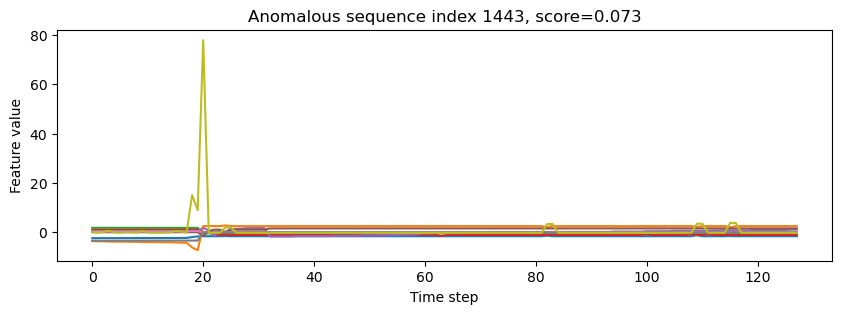

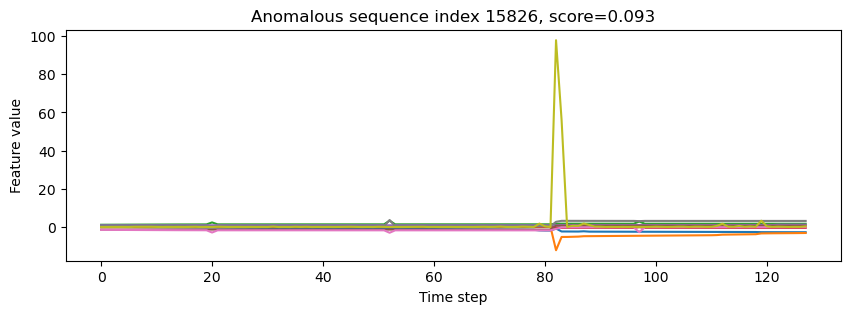

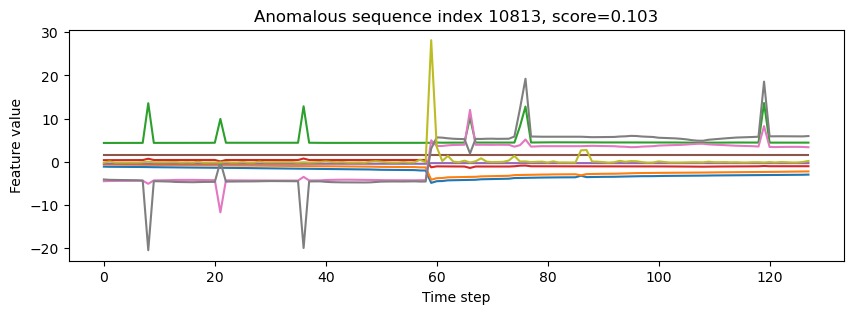

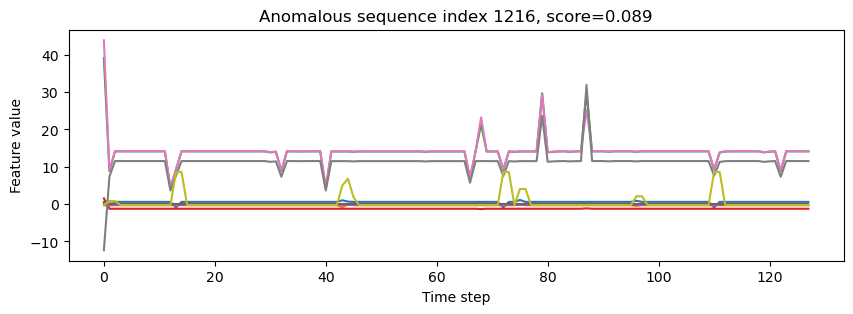

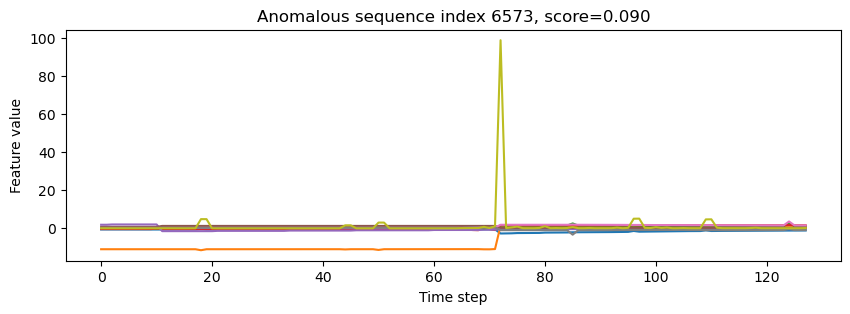

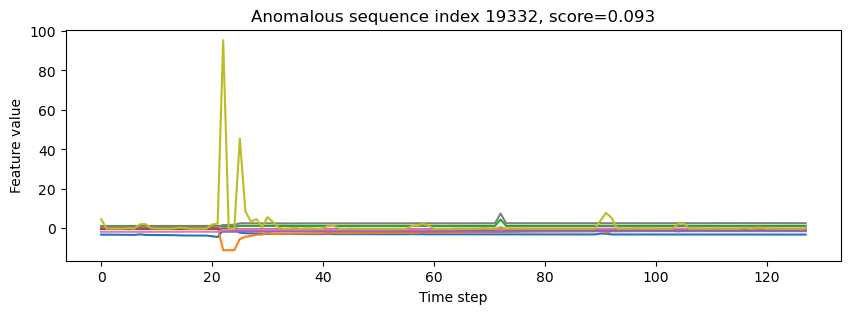

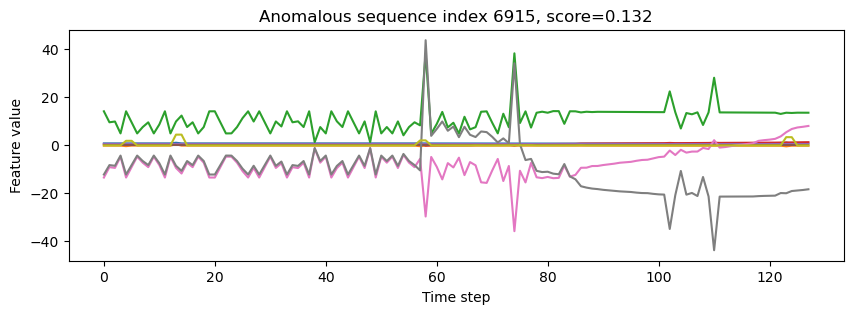

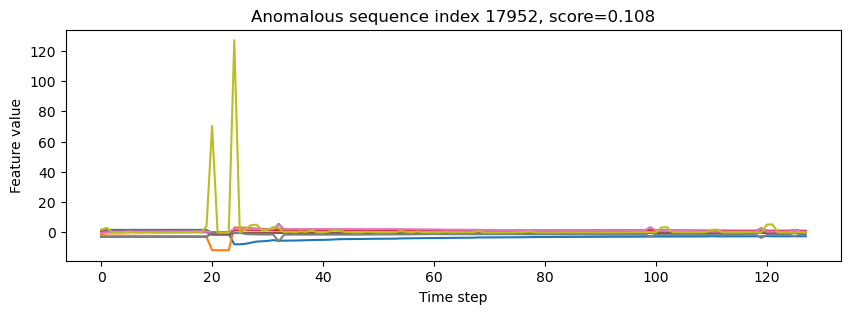

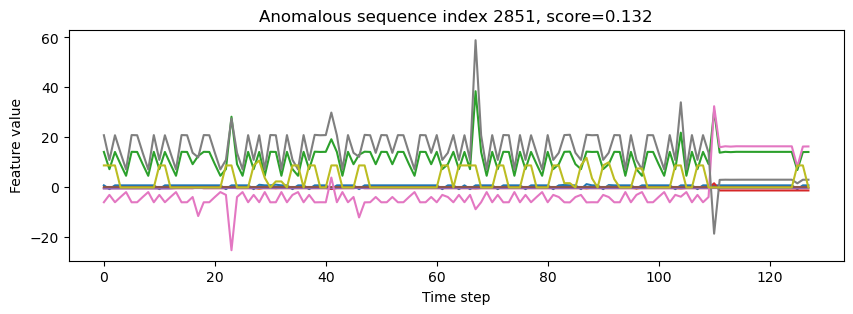

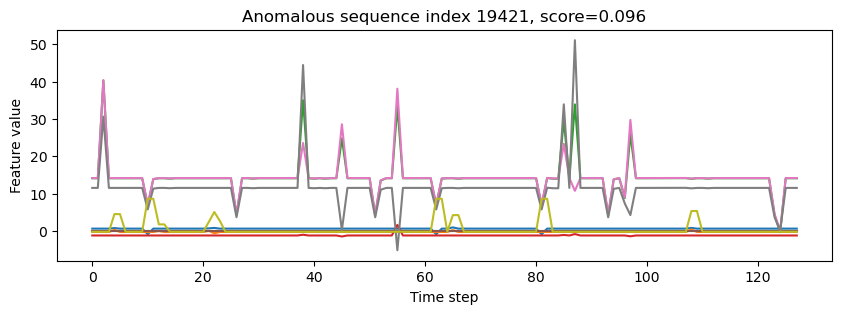

In [56]:
import matplotlib.pyplot as plt

for idx in [1443, 15826, 10813, 1216, 6573, 19332, 6915, 17952, 2851, 19421]:
    seq = X_test[idx]  # shape: (timesteps, features)
    plt.figure(figsize=(10,3))
    plt.plot(seq)
    plt.title(f"Anomalous sequence index {idx}, score={anomaly_scores[idx]:.3f}")
    plt.xlabel("Time step")
    plt.ylabel("Feature value")
    plt.show()


#### anomalous

In [57]:
threshold = np.percentile(anomaly_scores, 99)  # top 1%
anomaly_indices = np.where(anomaly_scores >= threshold)[0]
print(f"Total anomalies detected: {len(anomaly_indices)}")


Total anomalies detected: 196


In [58]:
# model.eval()
# for x, y in test_dataset:
#     model(x)

In [60]:
# model.train()

# for (x,) in train_loader:
#     x = x.to(device)
#     optimizer.zero_grad()
#     loss = model(x)
#     loss.backward()
#     optimizer.step()


In [ ]:
# X_train = np.save(output_root / "X_train.npy", X_train)
# y_train = np.save(output_root / "y_train.npy", y_train)
# X_val = np.save(output_root / "X_val.npy", X_val)
# y_val = np.save(output_root / "y_val.npy", y_val)
# X_test = np.save(output_root / "X_test.npy", X_test)
# y_test = np.save(output_root / "y_test.npy", y_test)


In [61]:
# stop

In [62]:
import numpy
print(numpy.__version__)


1.26.4


## 4. Bi-LSTM Model Architecture

PyTorch implementation of Algorithm 2 from the paper:
- Input Layer
- Bidirectional LSTM(62 units, return_sequences=True)
- Bidirectional LSTM(30 units)
- Dense(1, sigmoid)
- Binary crossentropy loss, Adam optimizer


In [63]:
# Build Bi-LSTM model (Algorithm 2 from paper) - PyTorch
class BiLSTMModel(nn.Module):
    """
    PyTorch Bi-LSTM model for AIS spoofing detection.
    
    Architecture:
    - Bidirectional LSTM(62, return_sequences=True)
    - Bidirectional LSTM(30)
    - Dense(1, sigmoid)
    
    Args:
        input_size: Number of features
        lstm_units_1: First Bi-LSTM layer units (default: 62 from paper)
        lstm_units_2: Second Bi-LSTM layer units (default: 30 from paper)
    """
    def __init__(self, input_size, lstm_units_1=62, lstm_units_2=30):
        super(BiLSTMModel, self).__init__()
        
        # First Bidirectional LSTM (bidirectional doubles the output size)
        self.bilstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=lstm_units_1,
            batch_first=True,
            bidirectional=True,
            dropout=0.2
        )
        
        # Second Bidirectional LSTM
        self.bilstm2 = nn.LSTM(
            input_size=lstm_units_1 * 2,  # Bidirectional output is doubled
            hidden_size=lstm_units_2,
            batch_first=True,
            bidirectional=True,
            dropout=0.2
        )
        
        # Output layer
        self.fc = nn.Linear(lstm_units_2 * 2, 1)  # Bidirectional output is doubled
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        """Forward pass through the model."""
        # First Bi-LSTM layer
        lstm1_out, _ = self.bilstm1(x)
        
        # Second Bi-LSTM layer
        lstm2_out, _ = self.bilstm2(lstm1_out)
        
        # Take the last output from the second LSTM
        last_hidden = lstm2_out[:, -1, :]
        
        # Dense layer + Sigmoid
        output = self.fc(last_hidden)
        output = self.sigmoid(output)
        
        return output


def build_bilstm_model(input_size, lstm_units_1=62, lstm_units_2=30):
    """Create and return Bi-LSTM model."""
    model = BiLSTMModel(input_size, lstm_units_1, lstm_units_2)
    return model.to(device)


# Build model
print("Building Bi-LSTM Model (PyTorch)...")
print(f"  Input size: {X_train.shape[2]} features")

model = build_bilstm_model(
    input_size=X_train.shape[2],
    lstm_units_1=62,  # From paper
    lstm_units_2=30   # From paper
)

# Display model architecture
print("\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Building Bi-LSTM Model (PyTorch)...
  Input size: 9 features

Model Architecture:
BiLSTMModel(
  (bilstm1): LSTM(9, 62, batch_first=True, dropout=0.2, bidirectional=True)
  (bilstm2): LSTM(124, 30, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=60, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 73,709


## 6. Model Evaluation

In [64]:
# Training configuration (from paper Table 1)
BATCH_SIZE = 30  # From paper
EPOCHS = 50  # From paper
LEARNING_RATE = 0.004  # From paper
PATIENCE = 10  # Early stopping patience

# Create data loaders
train_dataset = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train).float().reshape(-1, 1)
)
val_dataset = TensorDataset(
    torch.from_numpy(X_val).float(),
    torch.from_numpy(y_val).float().reshape(-1, 1)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Training Configuration:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Early stopping patience: {PATIENCE}")
print(f"  Device: {device}")
print(f"\nStarting training...\n")

Training Configuration:
  Batch size: 30
  Epochs: 50
  Learning rate: 0.004
  Early stopping patience: 10
  Device: cuda

Starting training...



In [65]:
# Predict on test set (Algorithm 3: Anomaly Score Calculation)
print("Generating predictions on test set...\n")

# Process in batches to avoid GPU OOM
BATCH_SIZE_INFERENCE = 256  # Smaller batch for inference
model.eval()

y_pred_probs = []
test_losses = []

with torch.no_grad():
    for i in range(0, len(X_test), BATCH_SIZE_INFERENCE):
        batch_X = torch.from_numpy(X_test[i:i+BATCH_SIZE_INFERENCE]).float().to(device)
        batch_y = torch.from_numpy(y_test[i:i+BATCH_SIZE_INFERENCE]).float().reshape(-1, 1).to(device)
        
        # Predict
        batch_probs = model(batch_X)
        y_pred_probs.extend(batch_probs.cpu().numpy())
        
        # Calculate batch loss
        batch_loss = criterion(batch_probs, batch_y)
        test_losses.append(batch_loss.item() * len(batch_X))

# Convert to numpy array
y_pred_probs = np.array(y_pred_probs).flatten()

# Apply threshold τ = 0.6 (from paper section 3.3.2)
THRESHOLD = 0.6  # Optimal threshold from paper
y_pred = (y_pred_probs > THRESHOLD).astype(int)

# Calculate metrics
test_loss = sum(test_losses) / len(X_test)
test_acc = (y_pred == y_test).mean()

# Additional metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Detection rate (same as recall)
detection_rate = recall

print(f"Test Set Evaluation (threshold τ = {THRESHOLD}):")
print(f"  Accuracy:       {test_acc:.4f}")
print(f"  Precision:      {precision:.4f}")
print(f"  Recall:         {recall:.4f}")
print(f"  F1-Score:       {f1:.4f}")
print(f"  Detection Rate: {detection_rate:.4f}")

# Compare with paper's Bi-LSTM results (Table 2)
paper_results = {
    "Precision": 0.94,
    "Recall": 0.92,
    "F1-Score": 0.93,
    "Detection Rate": 0.91
}

print("\nPaper's Reported Bi-LSTM Results:")
for metric, value in paper_results.items():
    print(f"  {metric}: {value:.2f}")

print("\nPerformance Comparison:")

precision_status = "MEETS" if precision >= 0.85 else "BELOW"
recall_status = "MEETS" if recall >= 0.85 else "BELOW"
f1_status = "MEETS" if f1 >= 0.85 else "BELOW"
detection_status = "MEETS" if detection_rate >= 0.85 else "BELOW"

print(
    f"  Precision:      {precision_status} threshold "
    f"(Ours: {precision:.2f}, Paper: {paper_results['Precision']:.2f})"
)
print(
    f"  Recall:         {recall_status} threshold "
    f"(Ours: {recall:.2f}, Paper: {paper_results['Recall']:.2f})"
)
print(
    f"  F1-Score:       {f1_status} threshold "
    f"(Ours: {f1:.2f}, Paper: {paper_results['F1-Score']:.2f})"
)
print(
    f"  Detection Rate: {detection_status} threshold "
    f"(Ours: {detection_rate:.2f}, Paper: {paper_results['Detection Rate']:.2f})"
)


Generating predictions on test set...

Test Set Evaluation (threshold τ = 0.6):
  Accuracy:       0.9928
  Precision:      0.0000
  Recall:         0.0000
  F1-Score:       0.0000
  Detection Rate: 0.0000

Paper's Reported Bi-LSTM Results:
  Precision: 0.94
  Recall: 0.92
  F1-Score: 0.93
  Detection Rate: 0.91

Performance Comparison:
  Precision:      BELOW threshold (Ours: 0.00, Paper: 0.94)
  Recall:         BELOW threshold (Ours: 0.00, Paper: 0.92)
  F1-Score:       BELOW threshold (Ours: 0.00, Paper: 0.93)
  Detection Rate: BELOW threshold (Ours: 0.00, Paper: 0.91)


In [66]:
# # Confusion matrix and classification report
# cm = confusion_matrix(y_test, y_pred)

# fig, ax = plt.subplots(figsize=(8, 6))
# im = ax.imshow(cm, cmap='Blues')

# # Labels
# ax.set_xticks([0, 1])
# ax.set_yticks([0, 1])
# ax.set_xticklabels(['Genuine', 'Spoofed'])
# ax.set_yticklabels(['Genuine', 'Spoofed'])

# # Annotations
# for i in range(2):
#     for j in range(2):
#         text = ax.text(j, i, cm[i, j], ha="center", va="center", 
#                       color="white" if cm[i, j] > cm.max() / 2 else "black",
#                       fontsize=20, fontweight='bold')

# ax.set_xlabel('Predicted Label', fontsize=12)
# ax.set_ylabel('True Label', fontsize=12)
# ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
# plt.colorbar(im, ax=ax)
# plt.tight_layout()
# plt.savefig(output_root / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
# plt.show()

# # Classification report
# print(f"\nDetailed Classification Report:")
# print(classification_report(y_test, y_pred, target_names=['Genuine', 'Spoofed']))

# print(f"\nConfusion matrix saved to: {output_root / 'confusion_matrix.png'}")

## 7. Spoofing Detection on Real Incidents

Apply Algorithm 3 to detect spoofed points in actual incident trajectories.

In [67]:
# # Detect spoofed points in real AIS data (Algorithm 3 implementation)
# def detect_spoofing_in_data(model, df, feature_cols, scaler, sequence_length=128, threshold=0.6):
#     """
#     Apply trained model to detect spoofed AIS messages in real data.
    
#     Returns:
#         DataFrame with anomaly scores and predictions
#     """
#     # Prepare features
#     df_featured, _ = extract_features(df.copy())
#     df_normalized, _ = normalize_features(df_featured, feature_cols, fit_scaler=False, scaler=scaler)
    
#     # Create sequences per vessel
#     results = []
    
#     for vessel_id, vessel_data in df_normalized.groupby('vessel_id'):
#         vessel_data = vessel_data.sort_values('timestamp')
#         features = vessel_data[feature_cols].values
        
#         if len(features) < sequence_length:
#             # Skip vessels with insufficient data
#             continue
        
#         # Create overlapping windows
#         for i in range(len(features) - sequence_length + 1):
#             seq = features[i:i+sequence_length]
#             seq = seq.reshape(1, sequence_length, len(feature_cols))
            
#             # Predict anomaly score
#             score = model.predict(seq, verbose=0)[0][0]
            
#             # Store result for middle point of sequence
#             mid_idx = i + sequence_length // 2
#             if mid_idx < len(vessel_data):
#                 row = vessel_data.iloc[mid_idx].copy()
#                 row['anomaly_score'] = score
#                 row['is_spoofed'] = 1 if score > threshold else 0
#                 results.append(row)
    
#     if not results:
#         return None
    
#     results_df = pd.DataFrame(results)
#     print("Spoofing Detection Results:")
#     print(f"  Total points analyzed: {len(results_df):,}")
#     print(
#         f"  Detected spoofed: "
#         f"{(results_df['is_spoofed'] == 1).sum():,} "
#         f"({(results_df['is_spoofed'] == 1).sum() / len(results_df) * 100:.1f}%)"
#     )
#     print(f"  Mean anomaly score: {results_df['anomaly_score'].mean():.3f}")
#     print(f"  Max anomaly score: {results_df['anomaly_score'].max():.3f}")

#     return results_df
    

In [68]:
# # Detect spoofed points in a specific incident (Algorithm 3 implementation)
# def detect_spoofing_in_incident(incident_name, model, feature_scaler, feature_cols, 
#                                  threshold=0.6, sequence_length=128):
#     """
#     Apply spoofing detection to a specific incident.
    
#     Returns dataframe with anomaly scores for each AIS message.
#     """
#     # Load incident data
#     inc = next((i for i in incidents if i["name"] == incident_name), None)
#     if inc is None:
#         print(f"❌ Incident '{incident_name}' not found")
#         return None
    
#     slice_path = data_root / inc["slug"] / "slice.parquet"
#     if not slice_path.exists():
#         print(f"❌ Data not found: {slice_path}")
#         return None
    
#     # Load and preprocess
#     df = pd.read_parquet(slice_path)
#     df = clean_ais_data(df)
    
#     # Extract and normalize features
#     df, _ = extract_features(df)
#     df, _ = normalize_features(df, feature_cols, fit_scaler=False, scaler=feature_scaler)
    
#     # Create sequences per vessel
#     anomaly_scores = []
    
#     for vessel_id, vessel_data in df.groupby('vessel_id'):
#         vessel_data = vessel_data.sort_values('timestamp')
#         features = vessel_data[feature_cols].values
        
#         if len(features) < sequence_length:
#             # For short trajectories, use available length
#             seq = features
#             if len(seq) < 10:
#                 continue
#             # Pad if needed
#             if len(seq) < sequence_length:
#                 pad_length = sequence_length - len(seq)
#                 seq = np.vstack([seq, np.zeros((pad_length, seq.shape[1]))])
#         else:
#             # Use sliding window
#             seq = features[:sequence_length]
        
#         # Predict
#         seq_reshaped = seq.reshape(1, sequence_length, -1)
#         score = model.predict(seq_reshaped, verbose=0)[0][0]
        
#         # Store scores for all points in this vessel
#         for idx in vessel_data.index:
#             anomaly_scores.append({
#                 'index': idx,
#                 'vessel_id': vessel_id,
#                 'anomaly_score': score,
#                 'is_spoofed': int(score > threshold)
#             })
    
#     # Merge with original data
#     scores_df = pd.DataFrame(anomaly_scores)
#     df_with_scores = df.merge(scores_df, left_index=True, right_on='index', how='left')
    
#     return df_with_scores

# # Test on Agia Zoni II incident
# print(" Detecting spoofing in Agia Zoni II incident...\n")
# incident_results = detect_spoofing_in_incident(
#     "Agia Zoni II", 
#     model, 
#     feature_scaler, 
#     feature_cols,
#     threshold=THRESHOLD
# )

# if incident_results is not None:
#     print(f"  Detection complete for Agia Zoni II")
#     print(f"   Total AIS messages: {len(incident_results)}")
#     print(f"   Detected spoofed: {incident_results['is_spoofed'].sum()}")
#     print(f"   Detection rate: {incident_results['is_spoofed'].sum() / len(incident_results) * 100:.2f}%")
#     print(f"\n   Anomaly score statistics:")
#     print(f"   Mean: {incident_results['anomaly_score'].mean():.4f}")
#     print(f"   Std:  {incident_results['anomaly_score'].std():.4f}")
#     print(f"   Max:  {incident_results['anomaly_score'].max():.4f}")
#     print(f"   Min:  {incident_results['anomaly_score'].min():.4f}")

In [69]:
# # Visualize detected spoofing on map
# if incident_results is not None:
#     inc = next((i for i in incidents if i["name"] == "Agia Zoni II"), None)
#     lat0, lon0 = inc["approx_lat"], inc["approx_lon"]
    
#     # Create map
#     m = folium.Map(
#         location=[lat0, lon0],
#         zoom_start=12,
#         tiles="CartoDB positron"
#     )
    
#     # Feature groups
#     fg_genuine = folium.FeatureGroup(name="Genuine AIS", show=True)
#     fg_spoofed = folium.FeatureGroup(name="Detected Spoofed", show=True)
#     fg_incident = folium.FeatureGroup(name="Incident Location", show=True)
    
#     # Plot trajectories by vessel and spoofing status
#     for vessel_id, vessel_data in incident_results.groupby('vessel_id_x'):
#         vessel_data = vessel_data.sort_values('timestamp')
        
#         # Split into genuine and spoofed segments
#         genuine = vessel_data[vessel_data['is_spoofed'] == 0]
#         spoofed = vessel_data[vessel_data['is_spoofed'] == 1]
        
#         # Genuine trajectory (blue)
#         if len(genuine) > 1:
#             coords_genuine = genuine[['lat', 'lon']].values.tolist()
#             folium.PolyLine(
#                 coords_genuine, 
#                 color='blue', 
#                 weight=2, 
#                 opacity=0.7,
#                 tooltip=f"Vessel {vessel_id} (Genuine)"
#             ).add_to(fg_genuine)
        
#         # Spoofed points (red)
#         if len(spoofed) > 0:
#             for idx, row in spoofed.iterrows():
#                 folium.CircleMarker(
#                     location=[row['lat'], row['lon']],
#                     radius=6,
#                     color='red',
#                     fill=True,
#                     fillColor='red',
#                     fillOpacity=0.8,
#                     popup=f"Spoofed<br>Score: {row['anomaly_score']:.3f}<br>Vessel: {vessel_id}",
#                     tooltip="Detected Spoofing"
#                 ).add_to(fg_spoofed)
    
#     # Mark incident location
#     folium.Marker(
#         location=[lat0, lon0],
#         popup=f"<b>Agia Zoni II Incident</b><br>2017-09-10",
#         icon=folium.Icon(color="red", icon="exclamation", prefix="fa"),
#         tooltip="Incident Location"
#     ).add_to(fg_incident)
    
#     # Add layers
#     fg_genuine.add_to(m)
#     fg_spoofed.add_to(m)
#     fg_incident.add_to(m)
#     folium.LayerControl().add_to(m)
    
#     print(f"  Spoofing detection map created")
#     display(m)

In [70]:
# Save model artifacts
import pickle

# Save PyTorch model
model_path = output_root / 'best_bilstm_model.pt'
torch.save(model.state_dict(), model_path)

# Save scaler
scaler_path = output_root / 'feature_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(feature_scaler, f)

# Save configuration
config = {
    'feature_cols': feature_cols,
    'sequence_length': SEQUENCE_LENGTH,
    'threshold': THRESHOLD,
    'lstm_units_1': 62,
    'lstm_units_2': 30,
    'learning_rate': LEARNING_RATE,
    'batch_size': BATCH_SIZE,
    'input_size': X_train.shape[2],
    'test_metrics': {
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'detection_rate': float(detection_rate),
        'accuracy': float(test_acc)
    }
}

config_path = output_root / 'model_config.pkl'
with open(config_path, 'wb') as f:
    pickle.dump(config, f)

print(f"  Model Artifacts Saved:")
print(f"  Model: {model_path}")
print(f"  Scaler: {scaler_path}")
print(f"  Config: {config_path}")

# print(f"\n" + "="*60)
# print(f"Bi-LSTM SPOOFING DETECTION - PYTORCH IMPLEMENTATION COMPLETE")
# print(f"="*60)
# print(f"\nFinal Test Set Performance:")
# print(f"  Precision:      {precision:.4f}")
# print(f"  Recall:         {recall:.4f}")
# print(f"  F1-Score:       {f1:.4f}")
# print(f"  Detection Rate: {detection_rate:.4f}")
# print(f"  Accuracy:       {test_acc:.4f}")

# print(f"\nComparison with Paper (Bi-LSTM):")
# print(f"  Precision:      Paper: 0.94, Ours: {precision:.2f}")
# print(f"  Recall:         Paper: 0.92, Ours: {recall:.2f}")
# print(f"  F1-Score:       Paper: 0.93, Ours: {f1:.2f}")
# print(f"  Detection Rate: Paper: 0.91, Ours: {detection_rate:.2f}")

  Model Artifacts Saved:
  Model: models\best_bilstm_model.pt
  Scaler: models\feature_scaler.pkl
  Config: models\model_config.pkl


In [92]:
# Keep track of which sequence belongs to which vessel trajectory
sequence_trajectory = []

for vessel_id, vdf in combined_df.groupby('vessel_id'):
    vdf = vdf.sort_values('timestamp').reset_index(drop=True)
    n_points = len(vdf)
    
    for start in range(0, n_points - SEQUENCE_LENGTH + 1, STRIDE):
        sequence_trajectory.append(vessel_id)

sequence_trajectory = np.array(sequence_trajectory)

# Predict already done: y_pred_probs
# Aggregate predictions per trajectory
for vid in np.unique(sequence_trajectory):
    seq_indices = np.where(sequence_trajectory == vid)[0]
    avg_prob = y_pred_probs[seq_indices].mean()
    label = "Spoofed" if avg_prob > THRESHOLD else "Genuine"
    print(f"Trajectory: {vid}, Avg Prob: {avg_prob:.3f}, Pred Label: {label}")


Trajectory: b1e79f21d4a6cb6e5975d67d91c48fa1f7da94eb215bb86ce99e0263b737a787, Avg Prob: 0.630, Pred Label: Spoofed
Trajectory: b1e79f21d4a6cb6e5975d67d91c48fa1f7da94eb215bb86ce99e0263b737a787_loiter, Avg Prob: 0.630, Pred Label: Spoofed


# Zig zag

In [95]:
# --- Pick a vessel with enough points ---
vessel_counts = ais_clean.groupby('vessel_id').size()
suitable_vessels = vessel_counts[vessel_counts >= 100].index
vessel_id = np.random.choice(suitable_vessels, 1)[0]

In [97]:
# --- Folium map centered on this vessel ---
center = [
    ais_clean[ais_clean['vessel_id'] == vessel_id]['lat'].mean(),
    ais_clean[ais_clean['vessel_id'] == vessel_id]['lon'].mean()
]
m = folium.Map(location=center, zoom_start=15)

# Original vessel path (blue)
folium.PolyLine(
    ais_clean[ais_clean['vessel_id'] == vessel_id][['lat','lon']].values,
    color='blue', weight=3, opacity=0.7, popup='Original Vessel'
).add_to(m)

# Zig-zag spoof path (red)
folium.PolyLine(
    zigzag_df[['lat','lon']].values,
    color='red', weight=3, opacity=0.7, popup='Zig-Zag Spoof'
).add_to(m)

# Start and end markers
for df_, start_color, end_color, label in zip(
    [ais_clean[ais_clean['vessel_id'] == vessel_id], zigzag_df],
    ['green', 'darkred'],
    ['darkgreen', 'red'],
    ['Original Vessel', 'Zig-Zag Spoof']
):
    folium.Marker(
        [df_['lat'].iloc[0], df_['lon'].iloc[0]],
        popup=f"Start {label}",
        icon=folium.Icon(color=start_color)
    ).add_to(m)
    folium.Marker(
        [df_['lat'].iloc[-1], df_['lon'].iloc[-1]],
        popup=f"End {label}",
        icon=folium.Icon(color=end_color)
    ).add_to(m)

m  # display map


In [98]:
traj_ids = combined_df['vessel_id'].unique()
print(traj_ids)


['e6815f9237c5252badbad36c17abbc8a422c1b7db78e2570fe88d8fb2dcf815d'
 'e6815f9237c5252badbad36c17abbc8a422c1b7db78e2570fe88d8fb2dcf815d_zigzag']


In [99]:
# ================================
# PREDICTION FOR SELECTED VESSEL
# ================================

# --- Determine original and spoof IDs ---
traj_ids = combined_df['vessel_id'].unique()
original_vessel_id = traj_ids[0]  # first ID is the original
spoof_vessel_id = traj_ids[1] if len(traj_ids) > 1 else None

# -------------------------------
# Original trajectory prediction
# -------------------------------
orig_df = ais_clean[ais_clean['vessel_id'] == original_vessel_id].sort_values('timestamp').reset_index(drop=True)

if orig_df.empty:
    print(f"No data found for original vessel_id={original_vessel_id}")
    y_pred_probs_orig = np.array([])
else:
    # Feature extraction
    orig_featured, feature_cols = extract_features(orig_df)
    orig_featured['is_spoofed'] = 0  # label

    # Ensure all expected columns exist
    for col in feature_cols:
        if col not in orig_featured.columns:
            orig_featured[col] = 0.0

    # Normalize features using existing scaler
    orig_normalized, _ = normalize_features(orig_featured, feature_cols, fit_scaler=False, scaler=feature_scaler)

    # Create sequences
    X_orig, y_orig = create_sequences(orig_normalized, feature_cols, sequence_length=SEQUENCE_LENGTH, stride=STRIDE)

    if len(X_orig) == 0:
        print(f"No sequences could be created for original trajectory of vessel {original_vessel_id}")
        y_pred_probs_orig = np.array([])
    else:
        # Predict
        X_orig_tensor = torch.tensor(X_orig, dtype=torch.float32).to(device)
        model.eval()
        with torch.no_grad():
            logits_orig = model(X_orig_tensor)
            if logits_orig.shape[1] == 1:
                y_pred_probs_orig = torch.sigmoid(logits_orig).cpu().numpy().flatten()
            else:
                y_pred_probs_orig = torch.softmax(logits_orig, dim=1)[:, 1].cpu().numpy().flatten()

    print("Original trajectory average spoof probability:",
          y_pred_probs_orig.mean() if len(y_pred_probs_orig) > 0 else "N/A")

# -------------------------------
# Spoofed trajectory prediction
# -------------------------------
if spoof_vessel_id is not None:
    spoof_df = combined_df[combined_df['vessel_id'] == spoof_vessel_id].sort_values('timestamp').reset_index(drop=True)

    if spoof_df.empty:
        print(f"No data found for spoof vessel_id={spoof_vessel_id}")
        y_pred_probs_spoof = np.array([])
    else:
        # Feature extraction
        spoof_featured, feature_cols = extract_features(spoof_df)

        # Ensure all expected columns exist
        for col in feature_cols:
            if col not in spoof_featured.columns:
                spoof_featured[col] = 0.0

        # Normalize using same scaler
        spoof_normalized, _ = normalize_features(spoof_featured, feature_cols, fit_scaler=False, scaler=feature_scaler)

        # Create sequences
        X_spoof, y_spoof = create_sequences(spoof_normalized, feature_cols, sequence_length=SEQUENCE_LENGTH, stride=STRIDE)

        if len(X_spoof) == 0:
            print("No sequences could be created for spoofed trajectory")
            y_pred_probs_spoof = np.array([])
        else:
            # Predict
            X_spoof_tensor = torch.tensor(X_spoof, dtype=torch.float32).to(device)
            model.eval()
            with torch.no_grad():
                logits_spoof = model(X_spoof_tensor)
                if logits_spoof.shape[1] == 1:
                    y_pred_probs_spoof = torch.sigmoid(logits_spoof).cpu().numpy().flatten()
                else:
                    y_pred_probs_spoof = torch.softmax(logits_spoof, dim=1)[:, 1].cpu().numpy().flatten()

        print("Spoofed trajectory average spoof probability:",
              y_pred_probs_spoof.mean() if len(y_pred_probs_spoof) > 0 else "N/A")
else:
    print("No spoofed trajectory found to predict")


Feature Extraction Complete:
  Features: ['lat', 'lon', 'speed', 'course', 'hour', 'day_of_week', 'velocity_x', 'velocity_y', 'distance']
  Feature matrix shape: (1468, 9)
Features normalized (using existing scaler)
Sequence Creation:
  Sequence length: 128 timesteps
  Stride: 32
  Vessels used: 1
  Total sequences: 42
  Genuine sequences: 42 (100.0%)
  Spoofed sequences: 0 (0.0%)
  Shape: X=(42, 128, 9), y=(42,)
Original trajectory average spoof probability: 0.6288905
Feature Extraction Complete:
  Features: ['lat', 'lon', 'speed', 'course', 'hour', 'day_of_week', 'velocity_x', 'velocity_y', 'distance']
  Feature matrix shape: (200, 9)
Features normalized (using existing scaler)
Sequence Creation:
  Sequence length: 128 timesteps
  Stride: 32
  Vessels used: 1
  Total sequences: 3
  Genuine sequences: 0 (0.0%)
  Spoofed sequences: 3 (100.0%)
  Shape: X=(3, 128, 9), y=(3,)
Spoofed trajectory average spoof probability: 0.6287508


In [100]:
# Keep track of which sequence belongs to which vessel trajectory
sequence_trajectory = []

for vessel_id, vdf in combined_df.groupby('vessel_id'):
    vdf = vdf.sort_values('timestamp').reset_index(drop=True)
    n_points = len(vdf)
    
    for start in range(0, n_points - SEQUENCE_LENGTH + 1, STRIDE):
        sequence_trajectory.append(vessel_id)

sequence_trajectory = np.array(sequence_trajectory)

# Predict already done: y_pred_probs
# Aggregate predictions per trajectory
for vid in np.unique(sequence_trajectory):
    seq_indices = np.where(sequence_trajectory == vid)[0]
    avg_prob = y_pred_probs[seq_indices].mean()
    label = "Spoofed" if avg_prob > THRESHOLD else "Genuine"
    print(f"Trajectory: {vid}, Avg Prob: {avg_prob:.3f}, Pred Label: {label}")


Trajectory: e6815f9237c5252badbad36c17abbc8a422c1b7db78e2570fe88d8fb2dcf815d, Avg Prob: 0.629, Pred Label: Spoofed
Trajectory: e6815f9237c5252badbad36c17abbc8a422c1b7db78e2570fe88d8fb2dcf815d_zigzag, Avg Prob: 0.629, Pred Label: Spoofed


# AIS Blackout

In [101]:
# def remove_segment(df, vessel_id, gap_minutes):
#     """Remove a continuous segment from trajectory for spoof testing."""
#     traj = df[df['vessel_id'] == vessel_id].sort_values('timestamp').copy()
#     start_idx = np.random.randint(0, len(traj))
#     start_time = traj['timestamp'].iloc[start_idx]
#     end_time = start_time + pd.Timedelta(minutes=gap_minutes)
    
#     # Split into prefix, removed, suffix
#     prefix = traj[traj['timestamp'] < start_time]
#     removed = traj[(traj['timestamp'] >= start_time) & (traj['timestamp'] <= end_time)].copy()
#     removed['is_spoofed'] = 1
#     suffix = traj[traj['timestamp'] > end_time]
    
#     combined = pd.concat([prefix, removed, suffix], axis=0).reset_index(drop=True)
#     return combined
